# Exploratory Data Analysis: Grantnav Dataset (Downloaded 20/04/2021)

**Research Question**
    
Is it possible to predict grant value from description keywords, location-based data and/or other characteristics?

## 0.0 Libraries

In [2]:
%load_ext autoreload
%autoreload 2

#system
import os
import sys
from os.path import join as pj
module_path = os.path.abspath(pj('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# data
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from dateutil.relativedelta import relativedelta
import datetime

# viz
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import missingno as msno

# configurations
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import configparser

# typing
from collections.abc import Iterable
from typing import TypeVar, Generic, Any

#stats
import scipy
import statsmodels.api as sm

# utils
from src.d00_utils import print_helper_functions as phf

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0.1 Configurations and Directories

In [3]:
# not used in this stub but often useful for finding various files
project_dir = Path().resolve().parents[1]
print(project_dir)

# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
_ = load_dotenv(find_dotenv())

raw_dir = pj(project_dir, 'data', os.environ.get('RAW_DIR'))
interim_dir = pj(project_dir, 'data', os.environ.get('INTERIM_DIR'))
processed_dir = pj(project_dir, 'data', os.environ.get('PROCESSED_DIR'))
reports_dir = pj(project_dir, 'data', os.environ.get('REPORTS_DIR'))

/Users/marclawson/repositories/grantnav_10k_predictor


## 1.0 Load Data

In [4]:
data = pd.read_csv(pj(interim_dir,'grantnav_data.csv'), index_col=0)

## 1.1 Size and shape

In [5]:
data.head()
data.shape

identifier currency  \
0  360G-SE-2011020480EXCH_2012-04-16      GBP   
1  360G-SE-2012000041EXCH_2012-04-16      GBP   
2  360G-SE-2012000173EXCH_2012-04-16      GBP   
3  360G-SE-2012000554EXCH_2012-04-16      GBP   
4  360G-SE-2010011194LOTT_2012-04-17      GBP   

                                               title  \
0                                 Active Men Project   
1                Sporting Futures Leadership Academy   
2                                            Choices   
3                                     Florrie Sports   
4  Engaging children and adults in Kwic Cricket s...   

                                         description  amount_awarded  \
0  Funding under Sport England's Sportsmatch fund...         41100.0   
1  Funding under Sport England's Sportsmatch fund...          6000.0   
2  Funding under Sport England's Sportsmatch fund...         36750.0   
3  Funding under Sport England's Sportsmatch fund...         15000.0   
4  Funding under Sport England's Small Grants fun...           692.0   

   award_date                 recipient_org_identifier  \
0  2012-04-16                          GB-COH-07626625   
1  2012-04-16                           GB-CHC-1041422   
2  2012-04-16                          GB-COH-01696490   
3  2012-04-16                          GB-COH-05330850   
4  2012-04-17  360G-SE-Barmston Village Primary School   

                     recipient_org_name funding_org_identifier  \
0  Positive Futures North Liverpool Ltd        GB-COH-RC000766   
1                      Sporting Futures        GB-COH-RC000766   
2                     Greenbank Project        GB-COH-RC000766   
3      The Florence Institute Trust Ltd        GB-COH-RC000766   
4       Barmston Village Primary School        GB-COH-RC000766   

  funding_org_name  planned_dates_duration_months  
0    Sport England                           11.0  
1    Sport England                           11.0  
2    Sport England                           11.0  
3    Sport England                           11.0  
4    Sport England                            3.0

(525023, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525023 entries, 0 to 561423
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   identifier                     525023 non-null  object 
 1   currency                       525023 non-null  object 
 2   title                          525023 non-null  object 
 3   description                    525023 non-null  object 
 4   amount_awarded                 525023 non-null  float64
 5   award_date                     525023 non-null  object 
 6   recipient_org_identifier       525023 non-null  object 
 7   recipient_org_name             525020 non-null  object 
 8   funding_org_identifier         525023 non-null  object 
 9   funding_org_name               525023 non-null  object 
 10  planned_dates_duration_months  525023 non-null  float64
dtypes: float64(2), object(9)
memory usage: 48.1+ MB


## 1.2 Grant Value Statistics (Handling Outliers)

In [7]:
grant_value = data['amount_awarded']
phf.print_full(grant_value.describe())

count             525,023.00
mean               39,985.73
std                78,117.54
min                   300.00
25%                 4,000.00
50%                 9,700.00
75%                30,000.00
max             1,381,438.97
Name: amount_awarded, dtype: float64

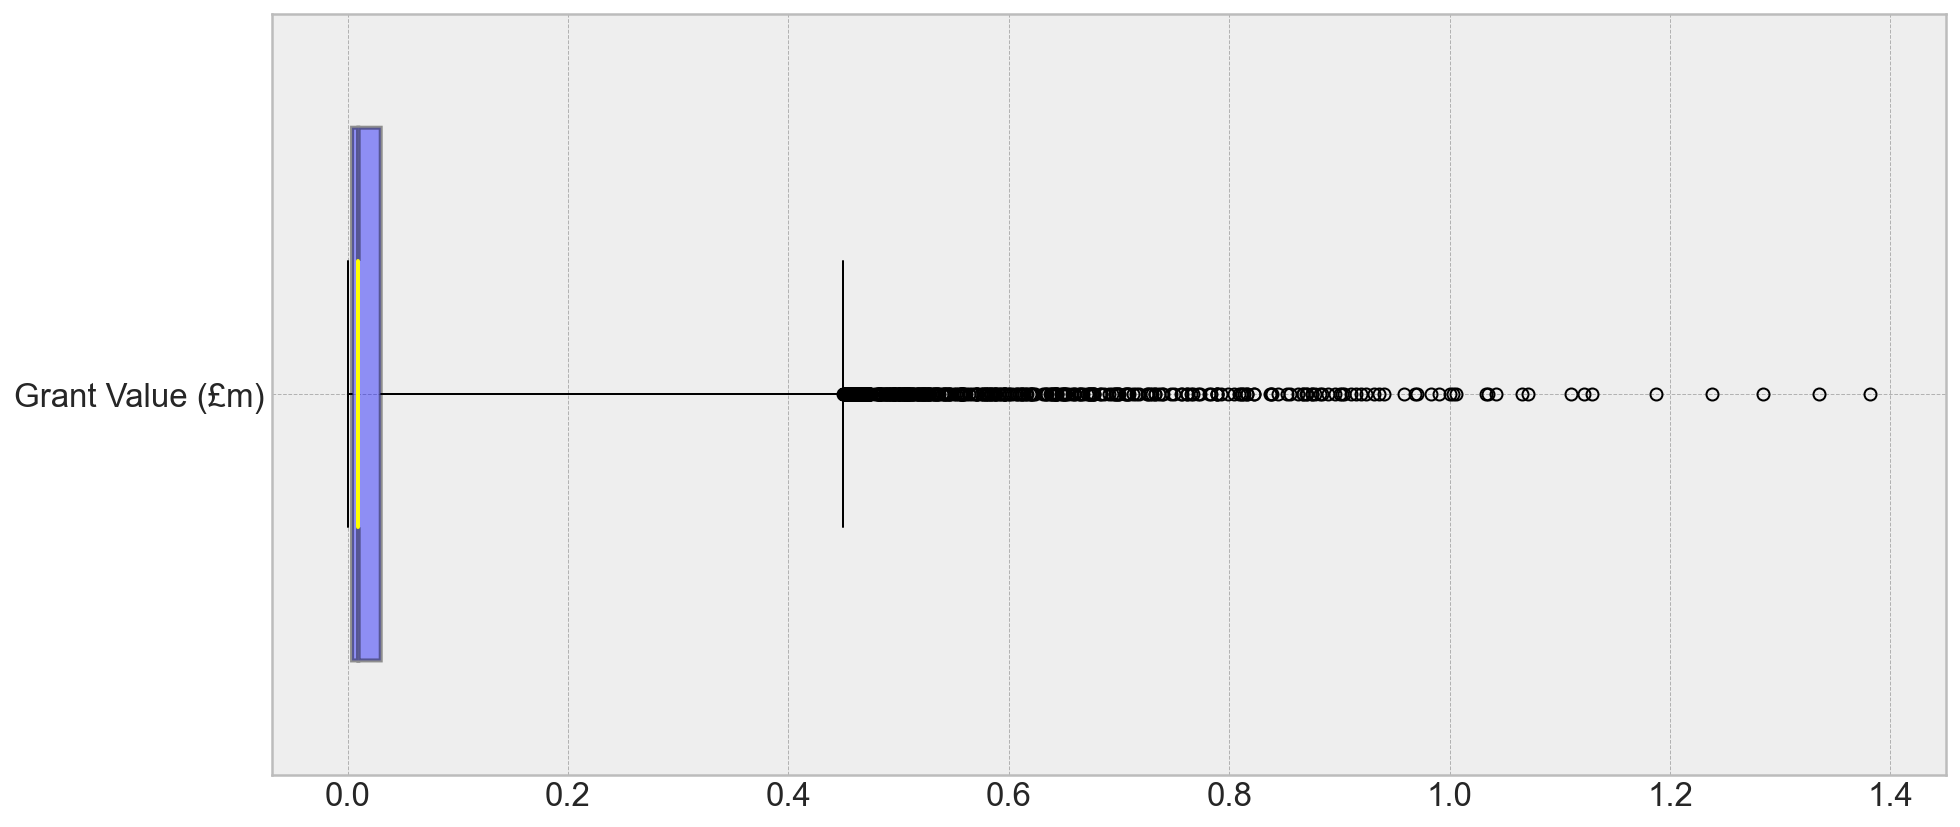

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
kwargs = {
    'vert': False,
    'whis': [0.3,99.7],
    'notch': True,
    'labels': [f'Grant Value (\u00A3m)'],
    'widths': .7,
    'patch_artist': True,
    'medianprops': dict(linestyle='-', linewidth=2, color='Yellow'),
    'boxprops': dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
}
ax.boxplot(grant_value/1000000, **kwargs)
plt.show();

## 1.3 Time Series (Award Date)

The remaining variables to investigate are the award dates and description word vectors.  I will investigate the time series first.

In [9]:
awards_by_date = data.groupby('award_date')['amount_awarded'].mean().reset_index()
awards_by_date['award_date'] = pd.to_datetime(awards_by_date['award_date'])
awards_by_date = awards_by_date.set_index('award_date',drop=True)

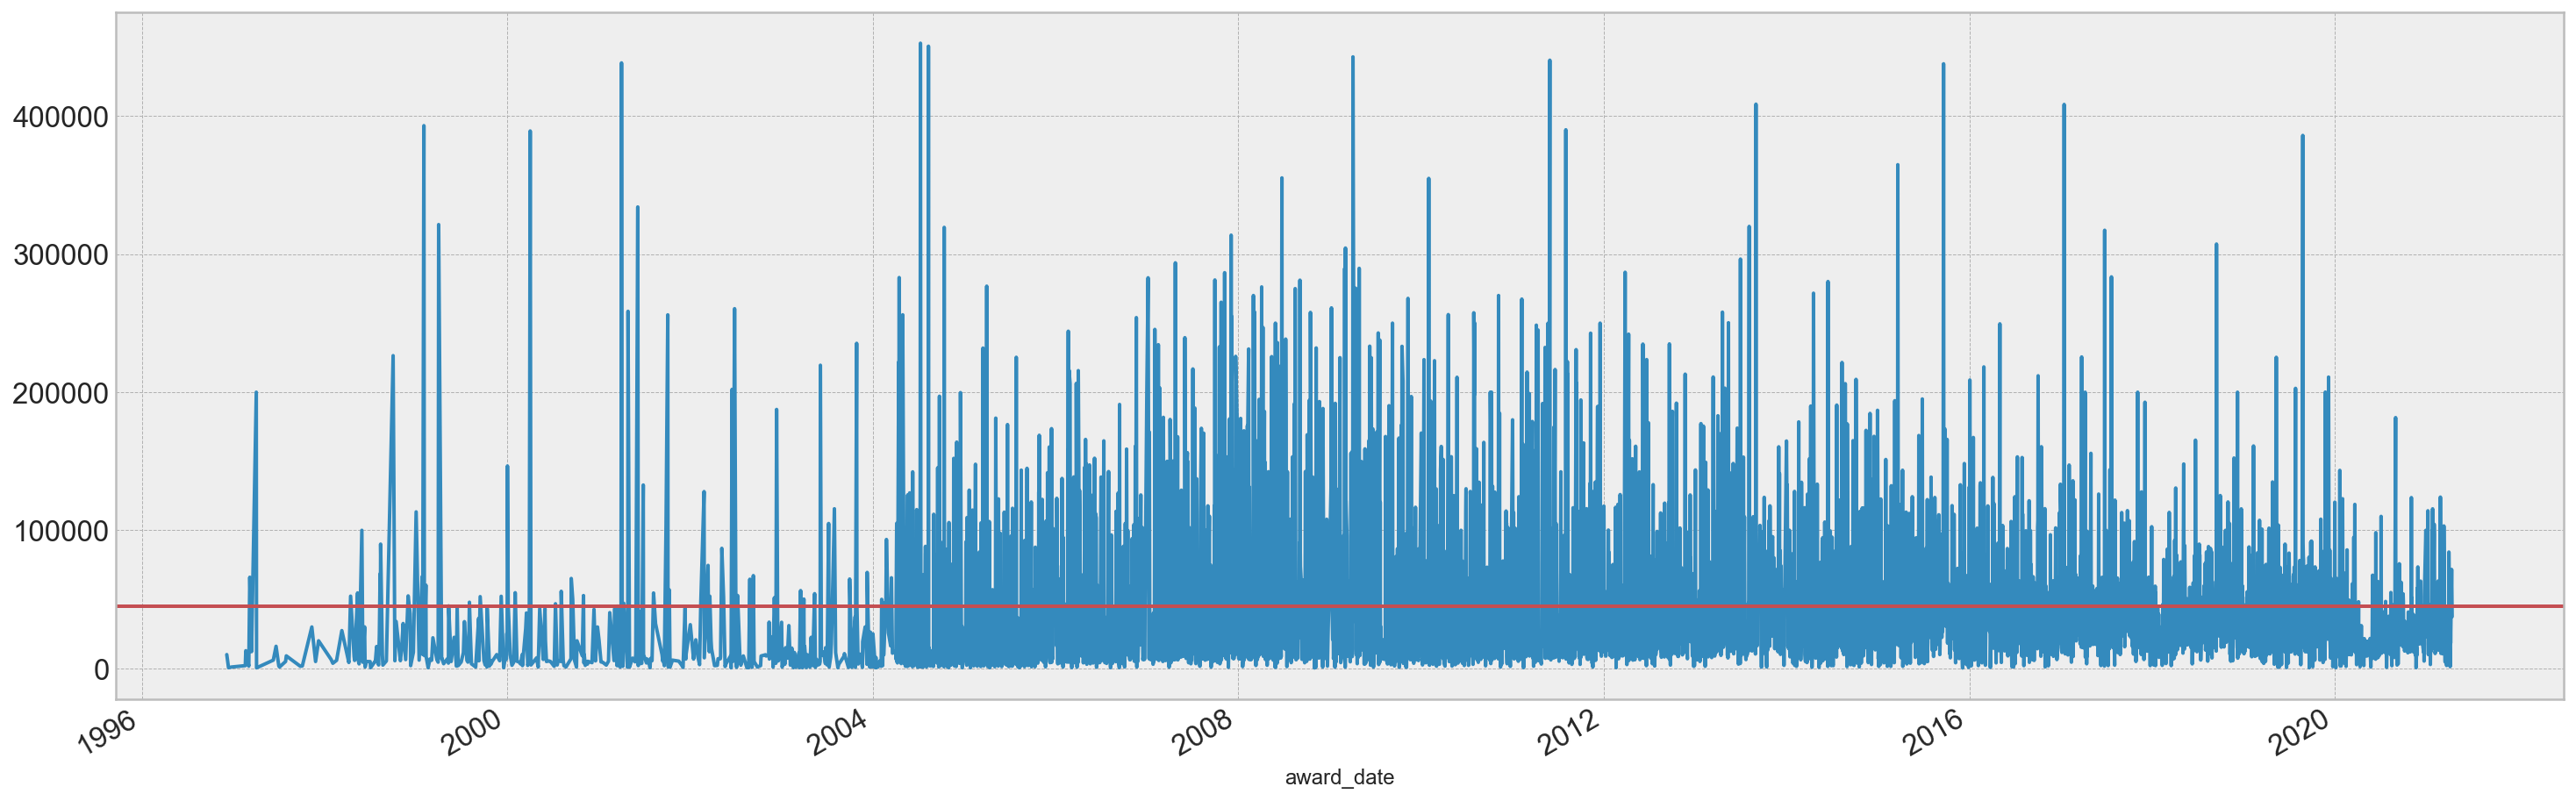

In [10]:
awards_by_date['amount_awarded'].plot(figsize=(25,8))
plt.axhline(awards_by_date['amount_awarded'].mean(), color='r')
plt.show();

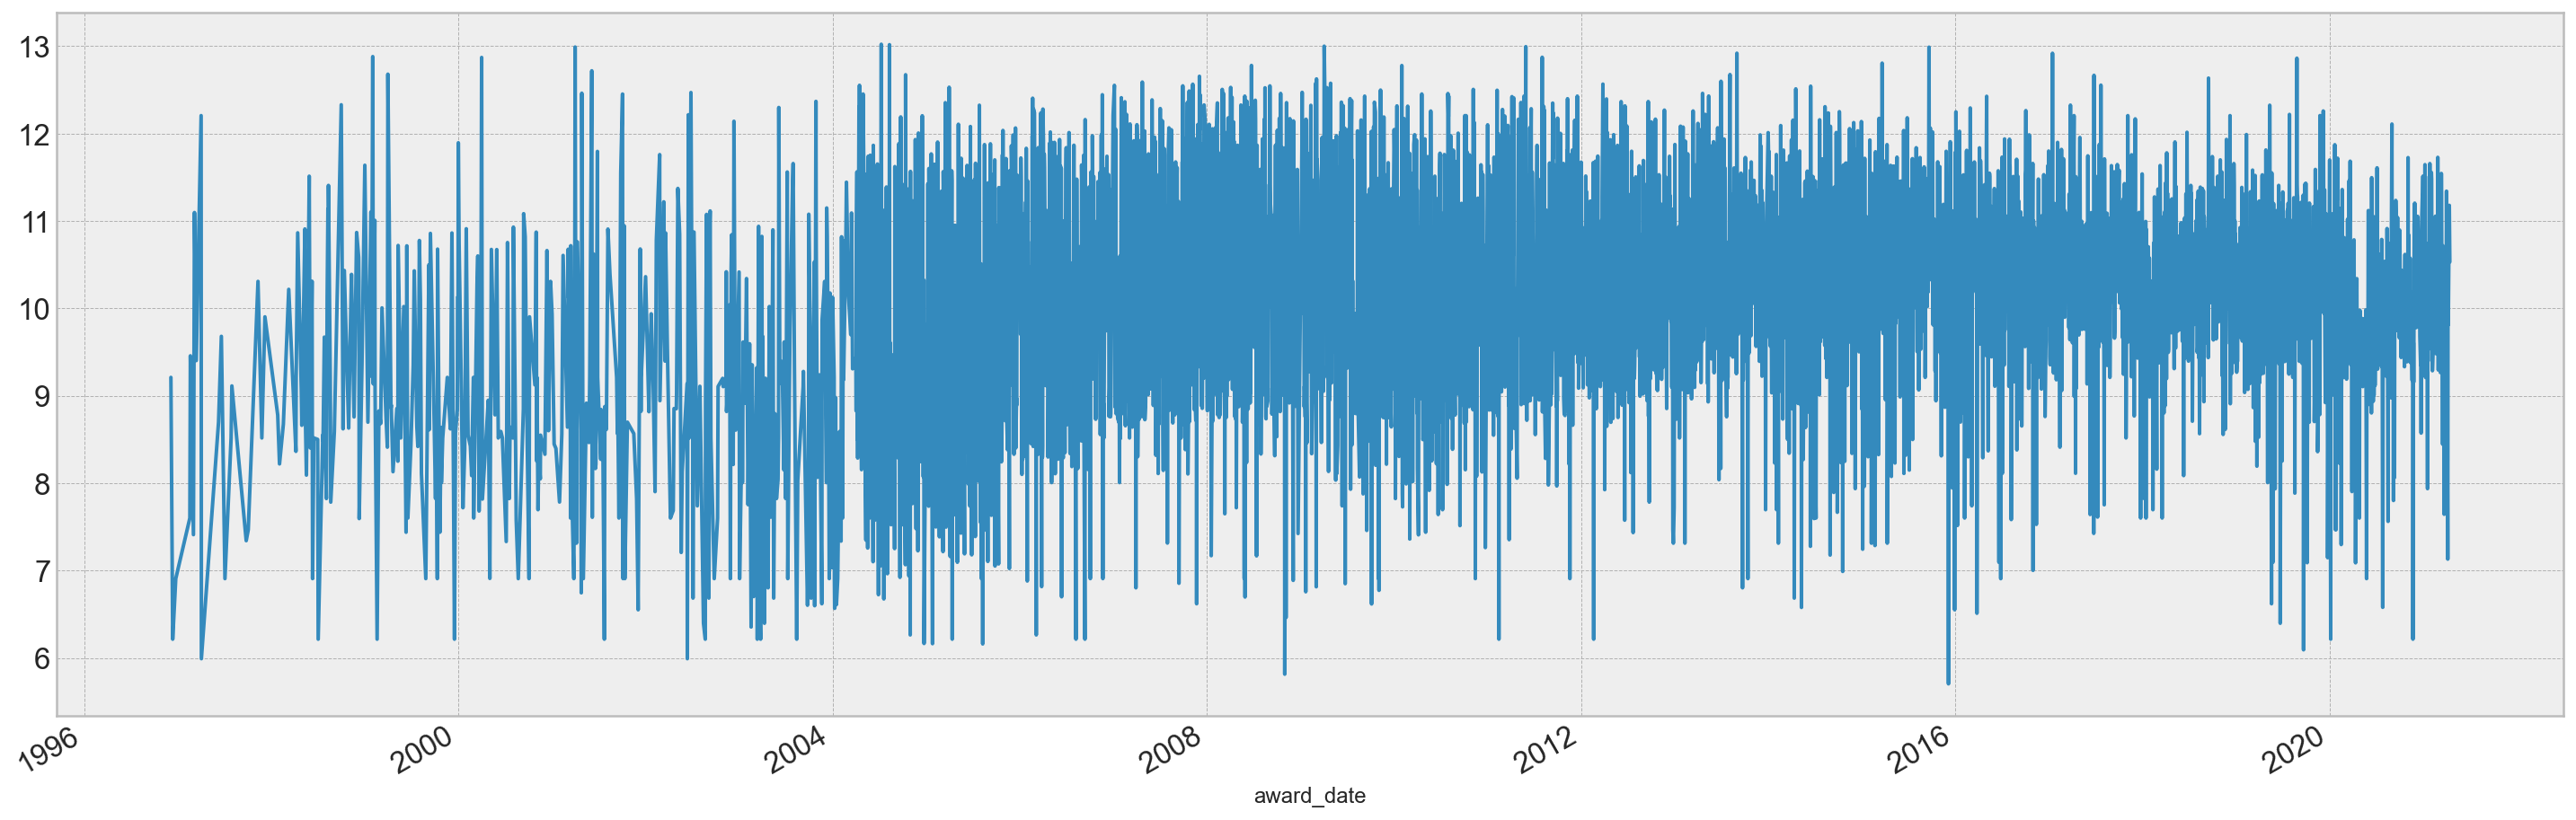

In [11]:
np.log(awards_by_date['amount_awarded']).plot(figsize=(25,8));

Check when the 'The National Lottery Community Fund' started to record data as there seems to be quite a volumn around 2004.

In [12]:
nat_lott = 'The National Lottery Community Fund'
nat_lott_record_start = data[data['funding_org_name']==nat_lott]['award_date'].min()
nat_lott_record_start

'2004-04-01'

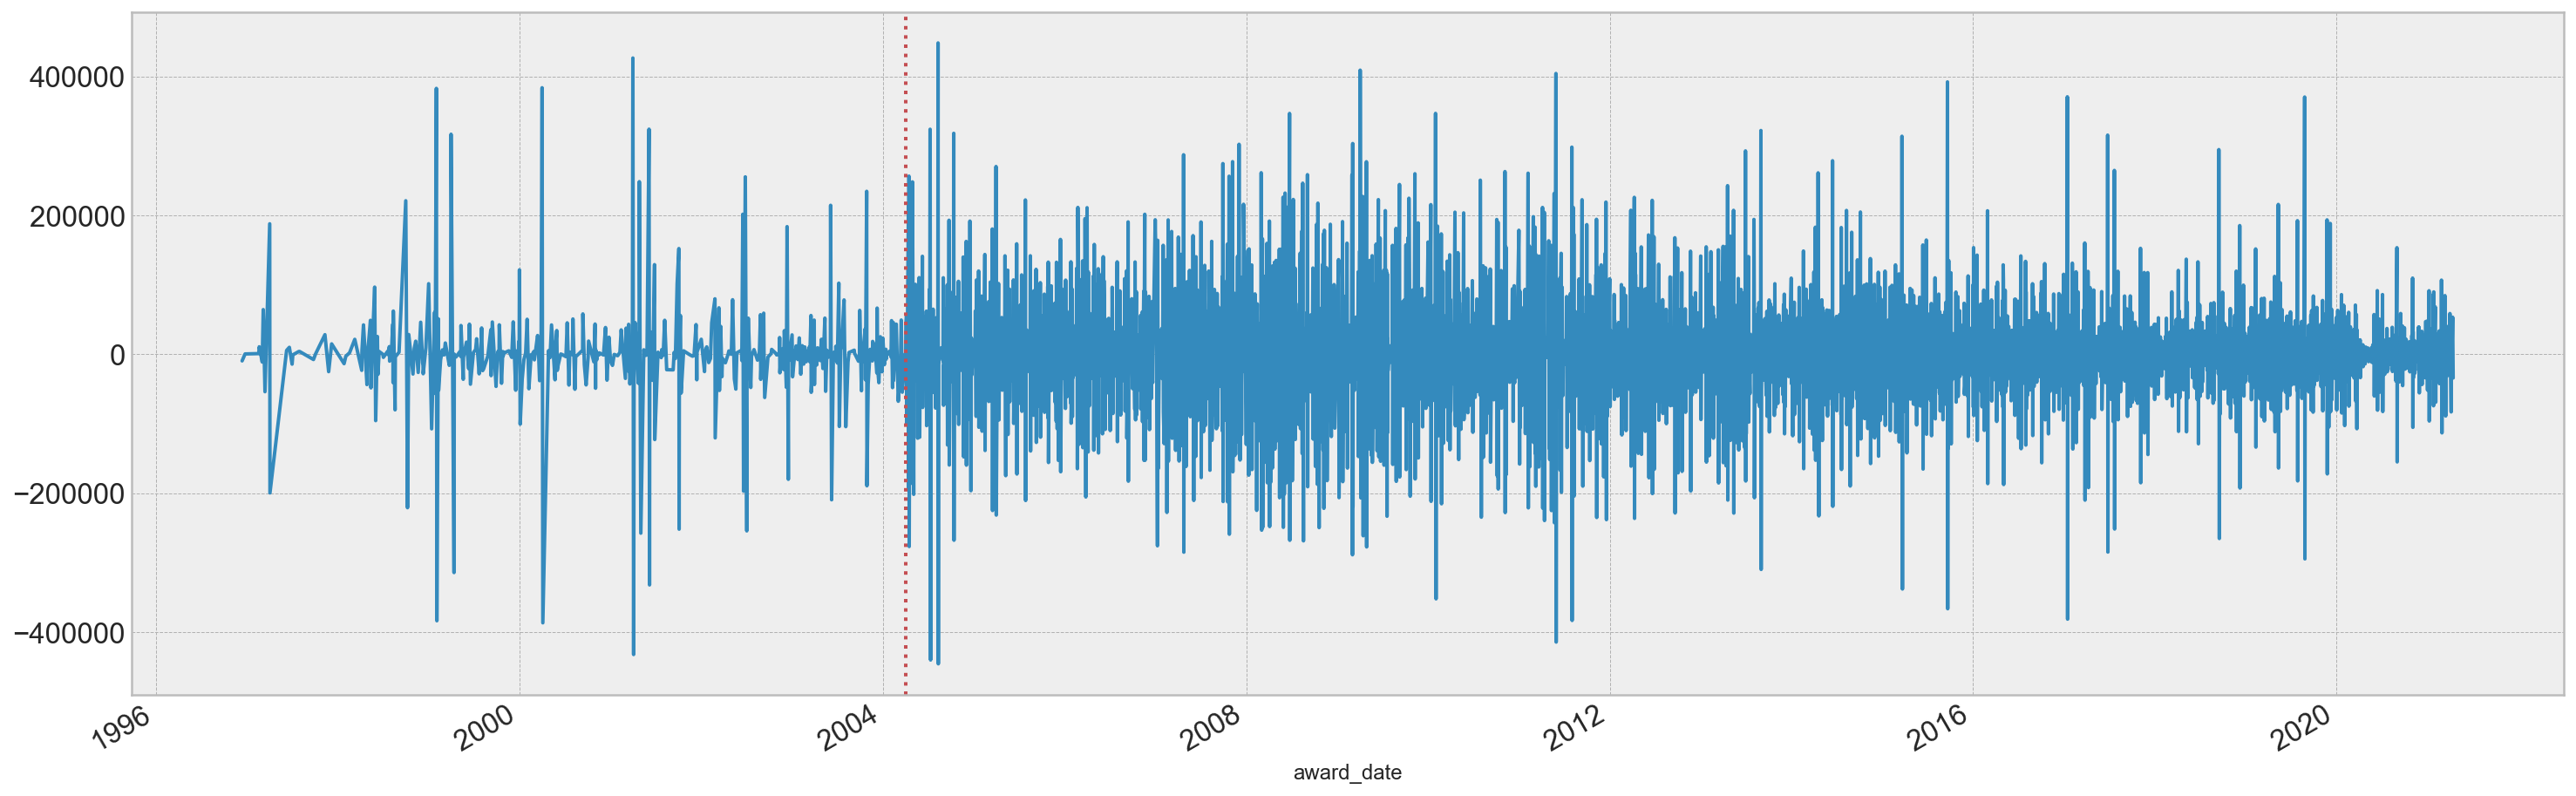

In [13]:
awards_by_date['amount_awarded'].diff().plot(figsize=(25,8))
plt.axvline(nat_lott_record_start, color='r',linestyle=':',linewidth=2)
plt.show();

#### Resample to weekly and monthly means

In [14]:
awards_by_date['amount_awarded'].head()

award_date
1996-12-05    10000.00
1996-12-12      500.00
1996-12-24     1000.00
1997-02-17     2000.00
1997-02-19    12801.81
Name: amount_awarded, dtype: float64

In [15]:
awards_by_date_pre2004 = awards_by_date[awards_by_date.index>=nat_lott_record_start]
awards_by_date_pre2004

amount_awarded
award_date                
2004-04-01    12541.579710
2004-04-02     6815.920635
2004-04-03    50000.000000
2004-04-05   105029.111111
2004-04-06     4928.823529
...                    ...
2021-04-06     1250.000000
2021-04-07    38497.186441
2021-04-08    18246.000000
2021-04-12    71634.000000
2021-04-14    37484.135135

[4867 rows x 1 columns]

In [16]:
awards_by_month = pd.DataFrame(awards_by_date_pre2004['amount_awarded'].resample('M').mean(),columns=['amount_awarded'])
awards_by_month

amount_awarded
award_date                
2004-04-30    75323.743469
2004-05-31    39106.325004
2004-06-30    27412.905141
2004-07-31    54719.422193
2004-08-31    31792.096439
...                    ...
2020-12-31    34866.189272
2021-01-31    36834.152151
2021-02-28    39693.666232
2021-03-31    27292.653059
2021-04-30    41893.365484

[205 rows x 1 columns]

What happens when we reduce to grants 10k or under?

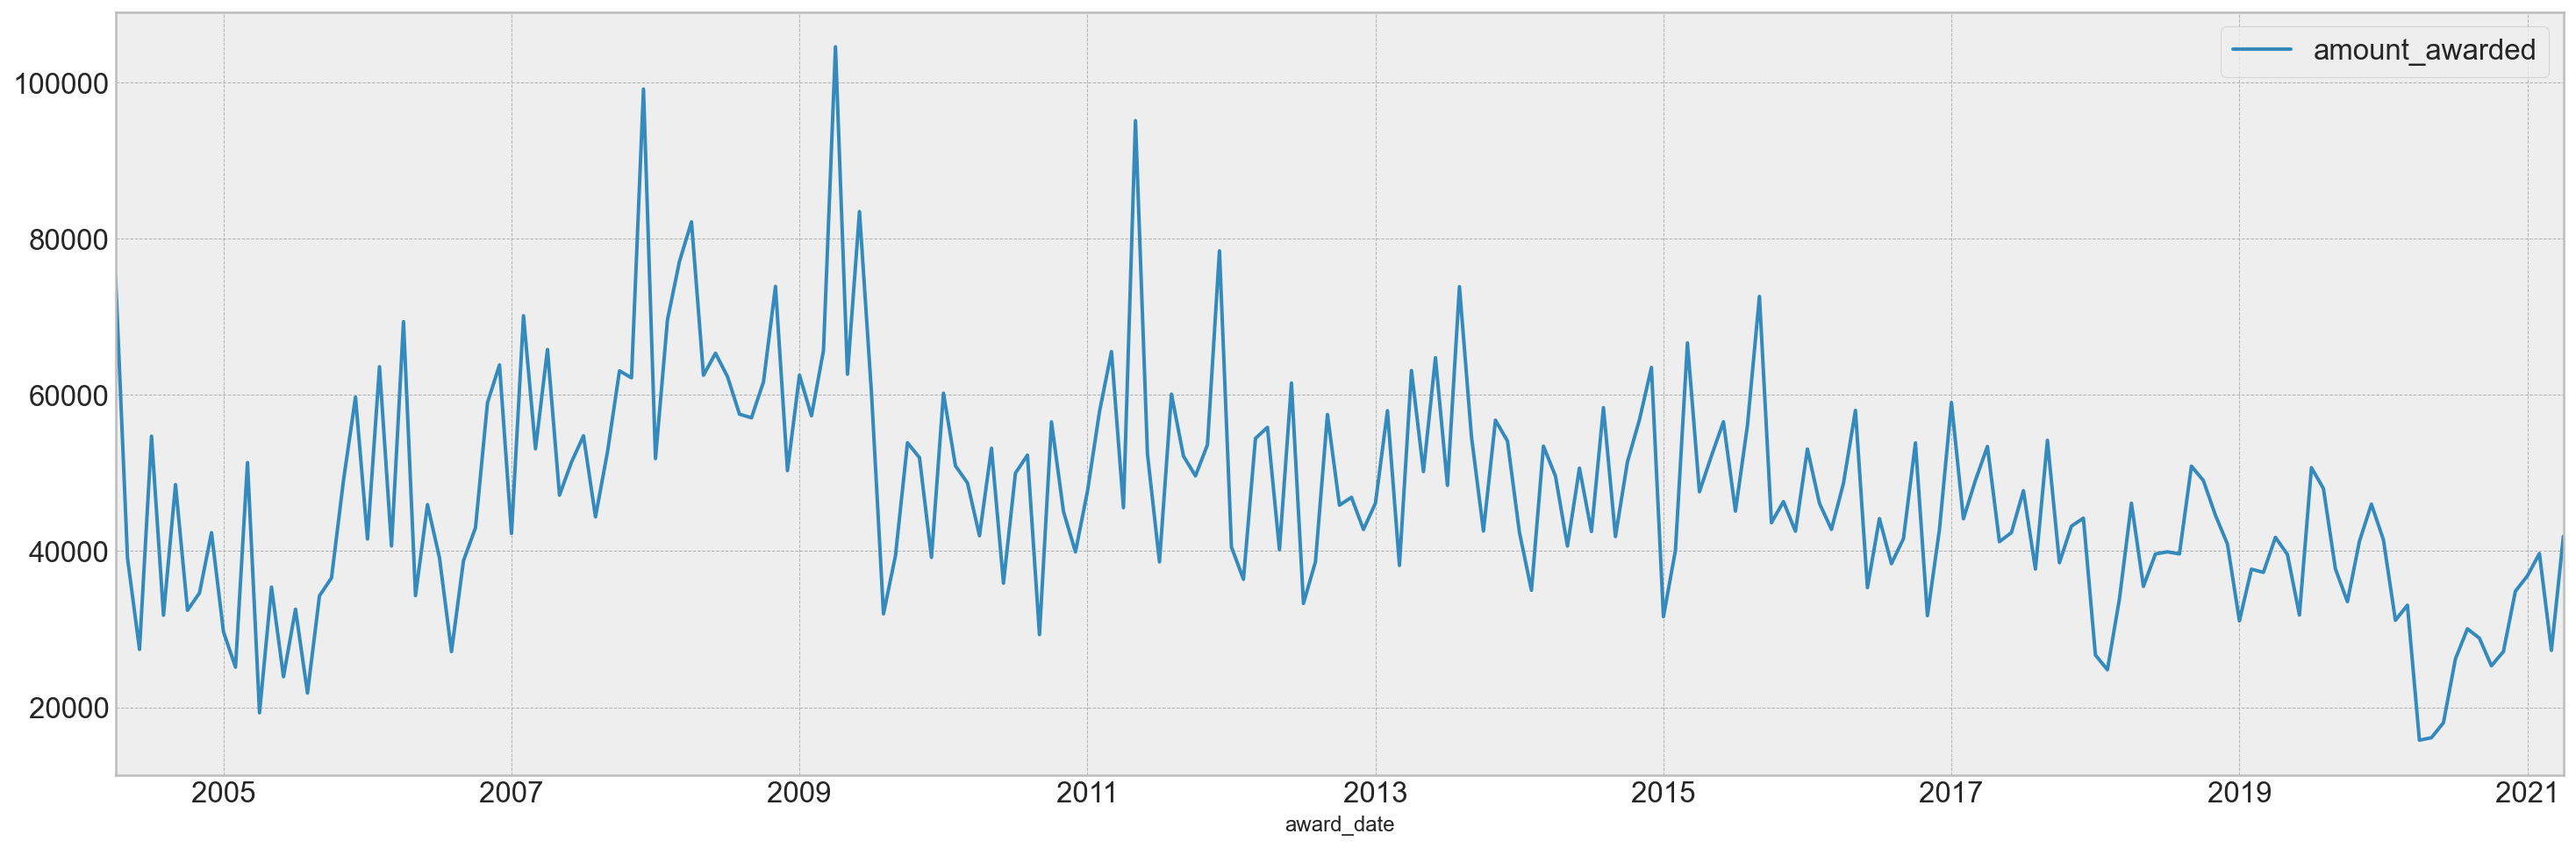

In [17]:
awards_by_month.plot(figsize=(25,8));

<AxesSubplot:xlabel='award_date'>

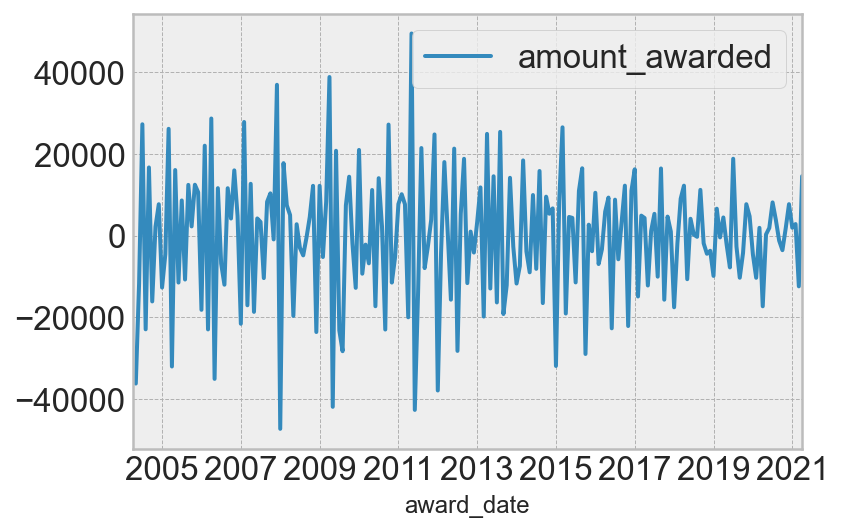

In [18]:
awards_by_month.diff().plot()

### 1.3.1 Ordinary Regression

In [19]:
awards_by_month['lag1'] = awards_by_month['amount_awarded'].shift(1)
shifted_1 = awards_by_month['lag1']

In [20]:
from sklearn.metrics import mean_squared_error
print(f"{mean_squared_error(awards_by_month['amount_awarded'].iloc[1:], shifted_1[1:]):,.0f}")

246,128,743


In [21]:
awards_by_month['amount_awarded'].iloc[1:]
shifted_1[1:]

award_date
2004-05-31    39106.325004
2004-06-30    27412.905141
2004-07-31    54719.422193
2004-08-31    31792.096439
2004-09-30    48518.841556
                  ...     
2020-12-31    34866.189272
2021-01-31    36834.152151
2021-02-28    39693.666232
2021-03-31    27292.653059
2021-04-30    41893.365484
Freq: M, Name: amount_awarded, Length: 204, dtype: float64

award_date
2004-05-31    75323.743469
2004-06-30    39106.325004
2004-07-31    27412.905141
2004-08-31    54719.422193
2004-09-30    31792.096439
                  ...     
2020-12-31    27137.775893
2021-01-31    34866.189272
2021-02-28    36834.152151
2021-03-31    39693.666232
2021-04-30    27292.653059
Freq: M, Name: lag1, Length: 204, dtype: float64

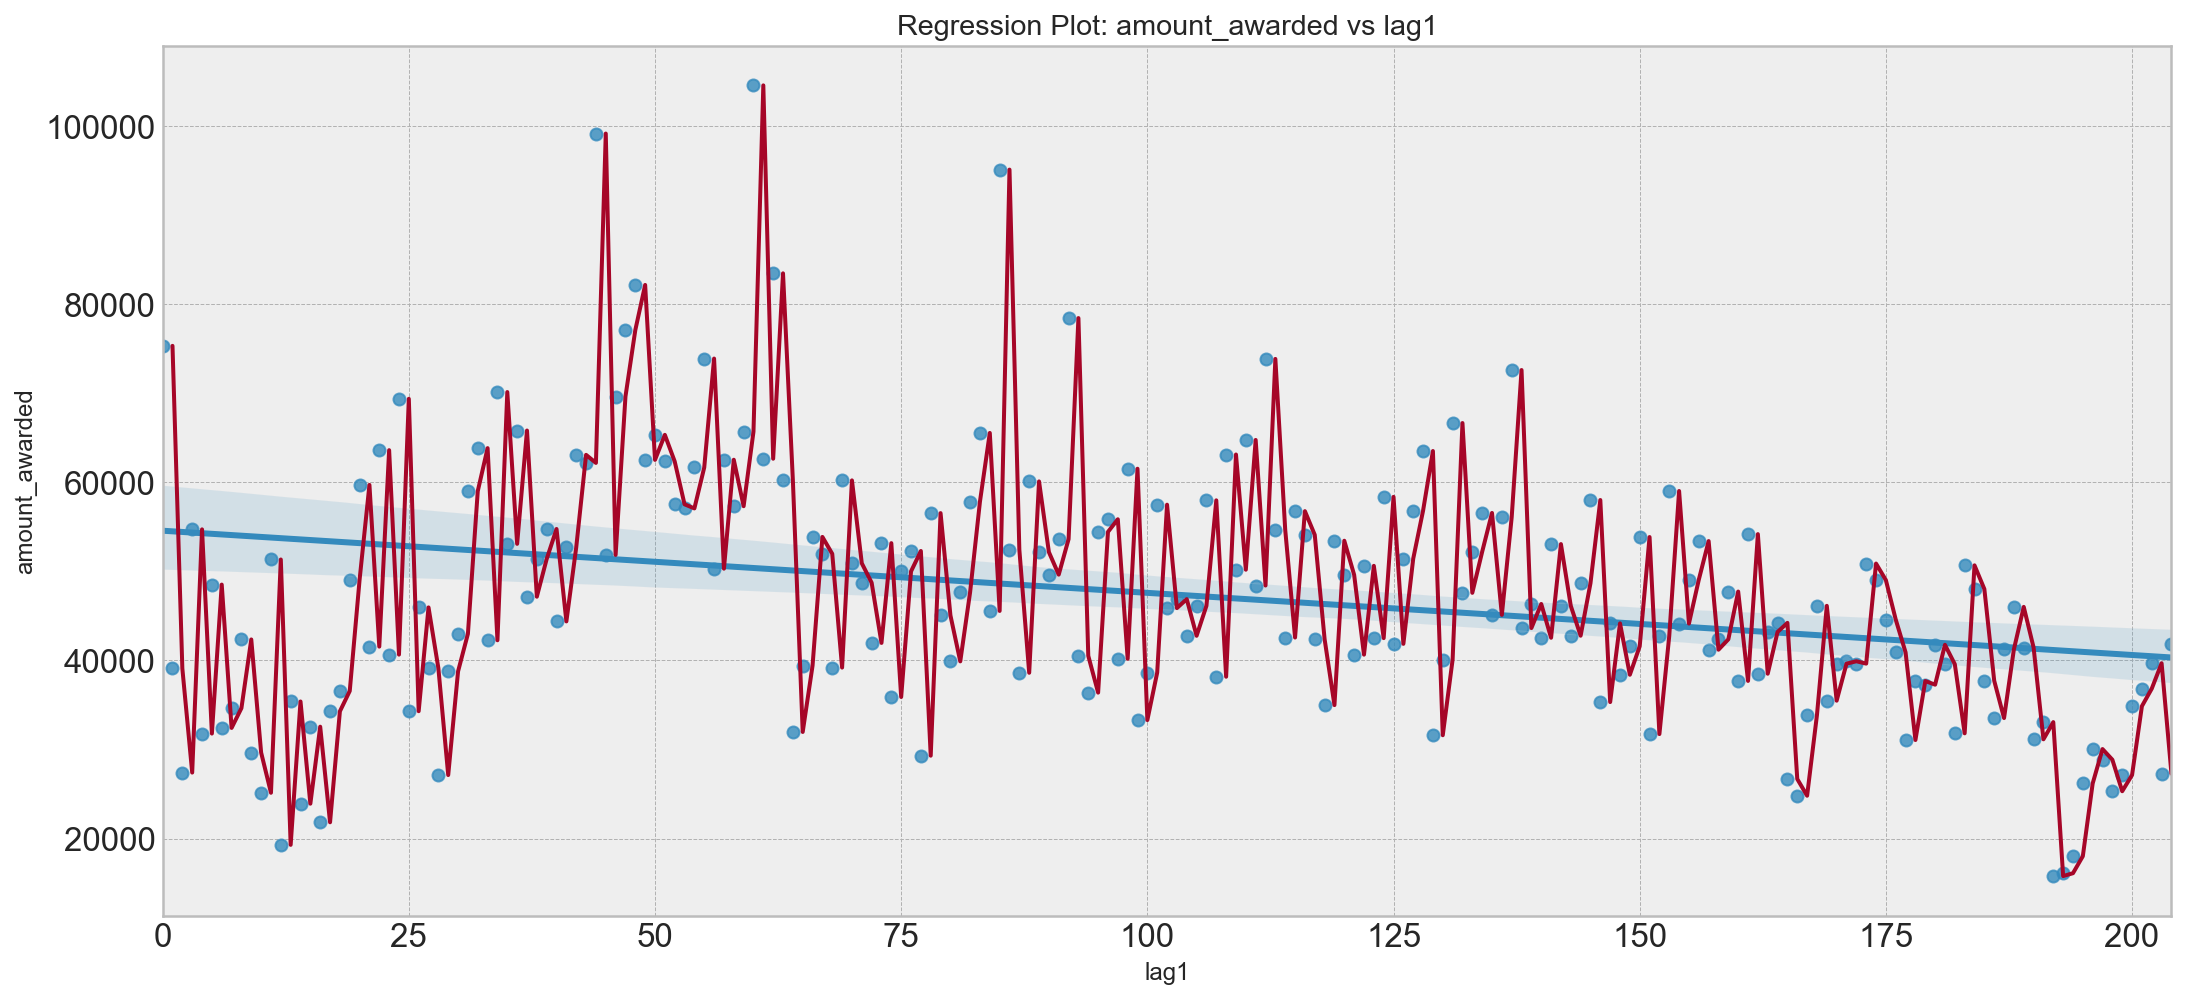

In [22]:
X = awards_by_month.reset_index().index
y = awards_by_month.amount_awarded

pred_values = awards_by_month['lag1']
fig, ax = plt.subplots(figsize=(18,8))
sns.regplot(x=X, y=y, data=awards_by_month, ax=ax)
ax.plot(X, pred_values)
ax.set_title('Regression Plot: amount_awarded vs lag1')
ax.set_xlabel('lag1')
plt.show();

There seems to be some sort of linear association between `amount_awarded` by month and its lag(1).

In [23]:
[(i, 
  mean_squared_error(awards_by_month['amount_awarded'].iloc[i:],
                     awards_by_month['amount_awarded'].shift(i).iloc[i:]))
  for i in range(1, 30)]

[(1, 246128742.52426788),
 (2, 225191616.82995856),
 (3, 220792147.2077153),
 (4, 265782247.36727434),
 (5, 279237238.3224743),
 (6, 292272519.7423159),
 (7, 272522373.57423496),
 (8, 312446253.3651682),
 (9, 307227670.83057064),
 (10, 291300945.88448805),
 (11, 299016230.2883104),
 (12, 281945817.8999665),
 (13, 278902263.85302484),
 (14, 305869518.06189877),
 (15, 331518256.02967155),
 (16, 287327331.8246836),
 (17, 354117671.83233905),
 (18, 341995645.8271561),
 (19, 340315321.4897885),
 (20, 363031732.7889575),
 (21, 355468214.5278956),
 (22, 347949994.3720781),
 (23, 309136774.5867516),
 (24, 340236543.57525223),
 (25, 314375420.0651553),
 (26, 336157437.9373561),
 (27, 359929923.48443556),
 (28, 361139314.56063086),
 (29, 385526909.4420076)]

In [24]:
# correlation lag1
X = awards_by_month[['amount_awarded','lag1']].copy()
X.dropna(inplace=True)

X.corr()

amount_awarded     lag1
amount_awarded         1.00000  0.39811
lag1                   0.39811  1.00000

Let's check correlations for lag3:

In [25]:
awards_by_month['lag3'] = awards_by_month['amount_awarded'].shift(3)
X = awards_by_month[['amount_awarded','lag3']].copy()
X.dropna(inplace=True)

X.corr()

amount_awarded      lag3
amount_awarded        1.000000  0.459283
lag3                  0.459283  1.000000

Let's do a linear regression model on lag1 and lag3

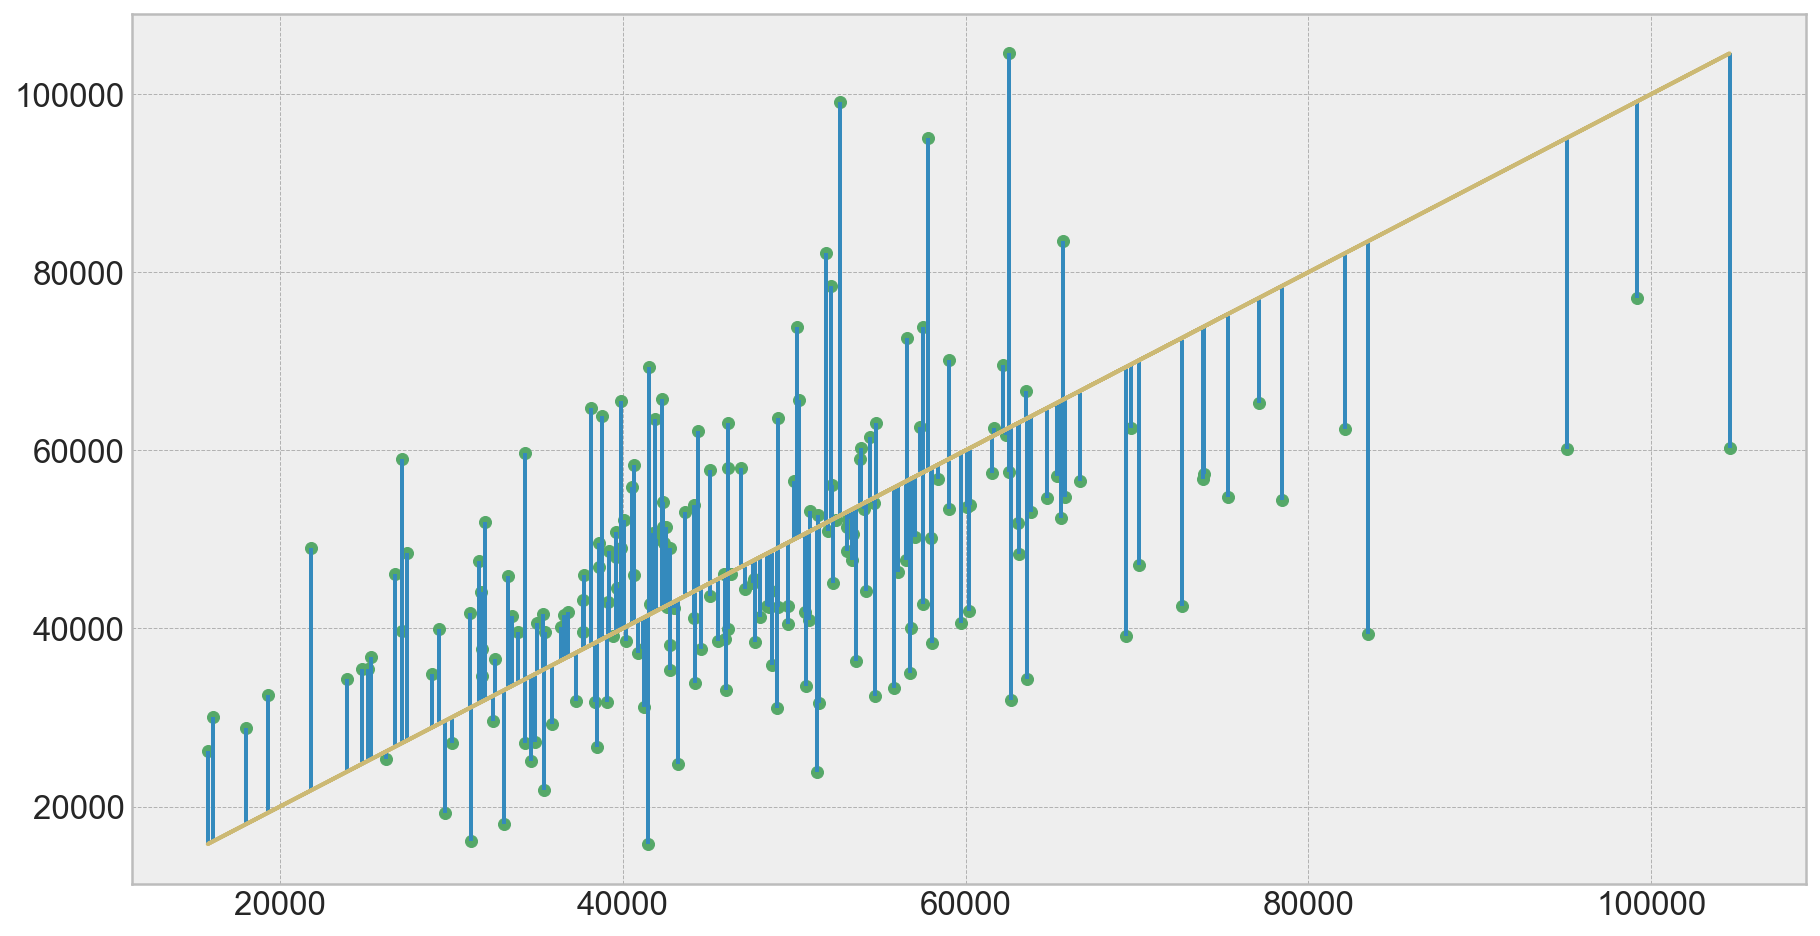

In [26]:
# plot residuals
df = awards_by_month.copy()
fig, ax = plt.subplots(figsize=(15,8))
predictor = 'lag3'
pred_values = df['lag3'].values
df['y_bar'] = df['amount_awarded'].mean()
baseline_residuals = [(i[0]-i[1]) for i in zip(df['amount_awarded'], df['y_bar'])]
new_residuals = [(i[0]-i[1]) for i in zip(df['amount_awarded'], pred_values)]
ax.scatter(df[predictor], df['amount_awarded'], color='g')
ax.plot(df[predictor], pred_values, color='y')
ax.vlines([x for x in df[predictor]], [p for p in pred_values], [y for y in df['amount_awarded']])
plt.show();

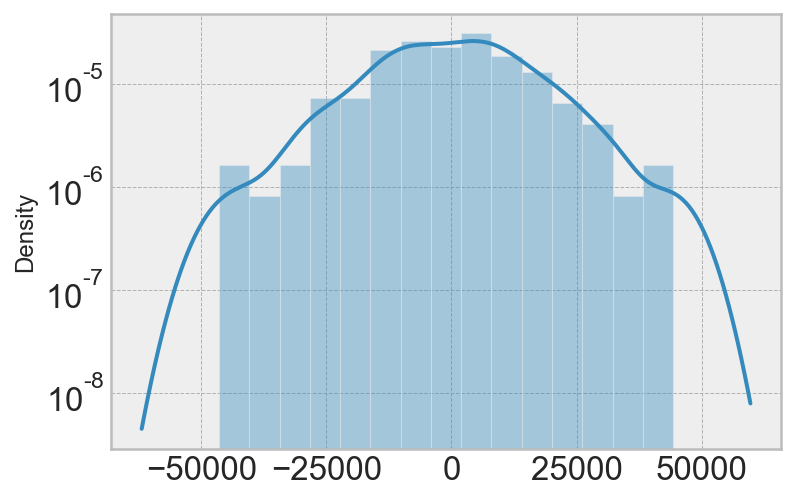

In [27]:
residuals = [i[0]-i[1] for i in zip(pred_values, df['amount_awarded'])]
sns.distplot(residuals)
plt.yscale('log')
plt.show;

In [28]:
df['residuals'] = residuals
df['pred_values'] = pred_values

In [29]:
df.residuals.map(lambda x: x**2).mean()
df.residuals.map(lambda x: x**2).mean()**0.5

220792147.20771533

14859.076256877994

In [30]:
np.allclose(sum(residuals[3:]), 0)

False

It looks like we're out by quite a bit.

If we were to integrate this into the models or the at least the prediction, historical data beyond the last five years may not be very useful.  What happens to the residuals if we look at data since 2016?

#### 5 Years Time Series

amount_awarded          diff
award_date                              
2016-06-19    13301.666667  -1262.356333
2016-06-26    19509.571429   6207.904762
2016-07-03    23482.142857   3972.571429
2016-07-10     9536.333333 -13945.809524
2016-07-17    32404.333333  22868.000000
...                    ...           ...
2021-03-21    15738.100000   2099.300000
2021-03-28    19251.083333   3512.983333
2021-04-04    20467.999203   1216.915869
2021-04-11    18832.000000  -1635.999203
2021-04-18    51977.000000  33145.000000

[253 rows x 2 columns]

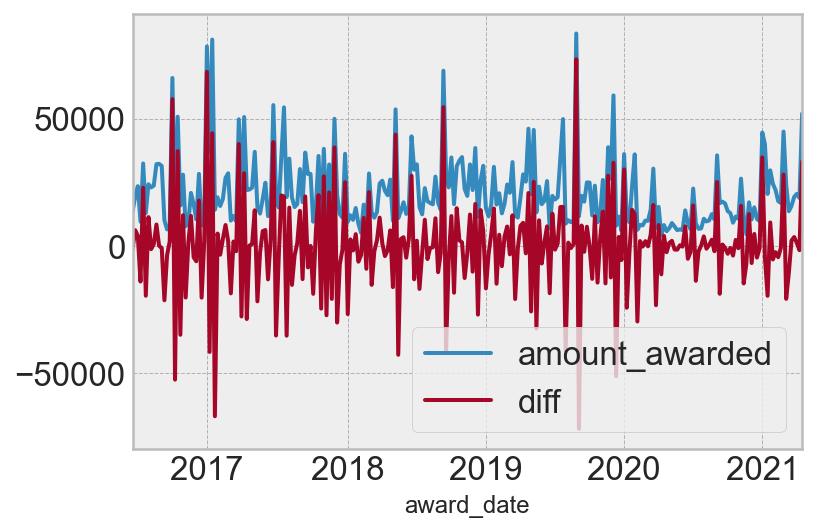

In [31]:
awards_by_week_5y = data.groupby('award_date')['amount_awarded'].median().reset_index()
awards_by_week_5y['award_date'] = pd.to_datetime(awards_by_week_5y['award_date'])
years_ago = datetime.datetime.now() - relativedelta(years=5)
awards_by_week_5y = awards_by_week_5y[awards_by_week_5y['award_date']>=years_ago]
awards_by_week_5y = awards_by_week_5y.set_index('award_date',drop=True)
awards_by_week_5y = pd.DataFrame(awards_by_week_5y.resample('W').mean() ,columns=['amount_awarded'])
awards_by_week_5y['diff'] = awards_by_week_5y['amount_awarded'].diff()
awards_by_week_5y = awards_by_week_5y.iloc[1:,:]
display(awards_by_week_5y)
awards_by_week_5y.plot();

In [32]:
[(i, 
  mean_squared_error(awards_by_week_5y['amount_awarded'].iloc[1+i:],
                     awards_by_week_5y['amount_awarded'].iloc[:].shift(i).iloc[1+i:]))
  for i in range(1, 30)]

[(1, 364715505.51017207),
 (2, 310957138.38252366),
 (3, 391451916.60645103),
 (4, 350360726.9928012),
 (5, 361410453.5399214),
 (6, 348296105.5656112),
 (7, 344643529.16570073),
 (8, 365251713.6111737),
 (9, 391296858.9370254),
 (10, 356283726.8558553),
 (11, 339622178.0961433),
 (12, 338782643.3242786),
 (13, 308343441.5405761),
 (14, 365344898.8886112),
 (15, 342836435.4307922),
 (16, 406273431.7895124),
 (17, 349021960.3272564),
 (18, 332796971.41553307),
 (19, 336030159.85548776),
 (20, 381129323.11869025),
 (21, 368911564.3754332),
 (22, 406726667.53445375),
 (23, 338005190.02208406),
 (24, 371555071.6775344),
 (25, 354983255.0985816),
 (26, 382917150.3172812),
 (27, 366431501.4748399),
 (28, 389379888.6528087),
 (29, 350944751.5105514)]

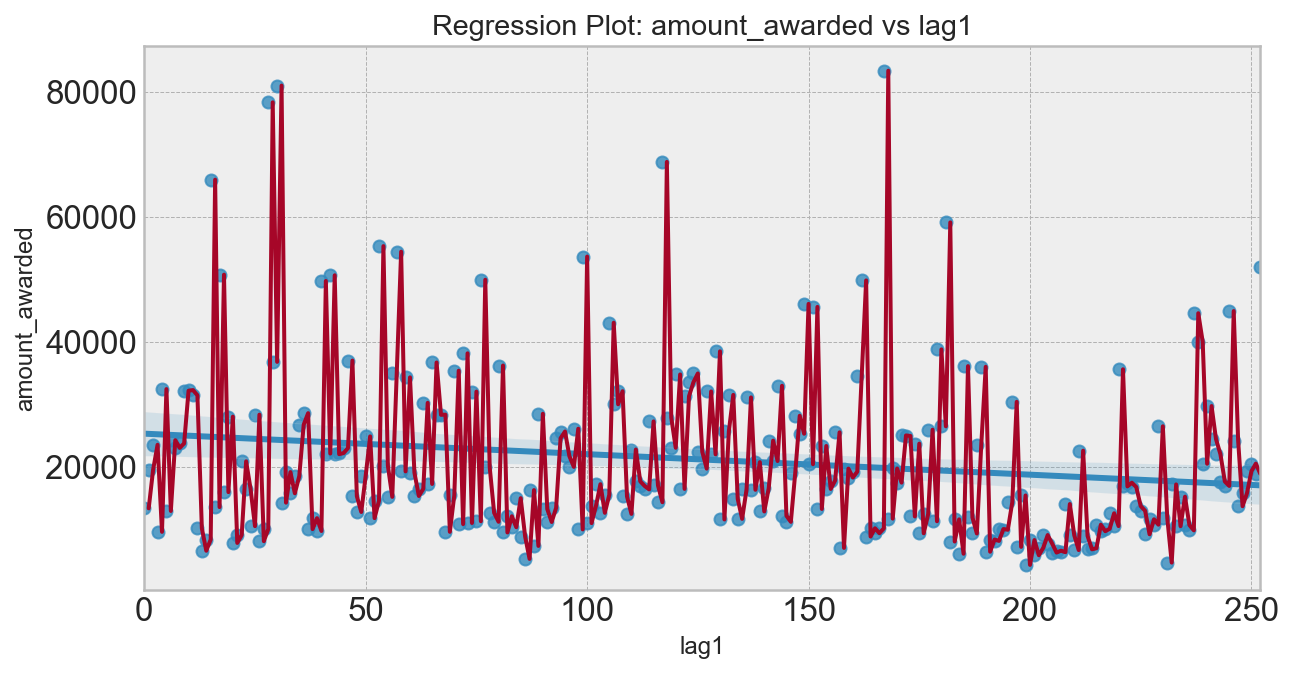

In [33]:
awards_by_week_5y['lag2'] = awards_by_week_5y['amount_awarded'].shift(1)
X = awards_by_week_5y.reset_index().index
y = awards_by_week_5y.amount_awarded

pred_values = awards_by_week_5y['lag2']
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x=X, y=y, data=awards_by_week_5y, ax=ax)
ax.plot(X, pred_values)
ax.set_title('Regression Plot: amount_awarded vs lag1')
ax.set_xlabel('lag1')
plt.show();

In [34]:
awards_by_week_5y['lag2'] = awards_by_week_5y['amount_awarded'].shift(3)
X = awards_by_week_5y[['amount_awarded','lag2']].copy()
X.dropna(inplace=True)

X.corr()

amount_awarded      lag2
amount_awarded        1.000000 -0.031973
lag2                 -0.031973  1.000000

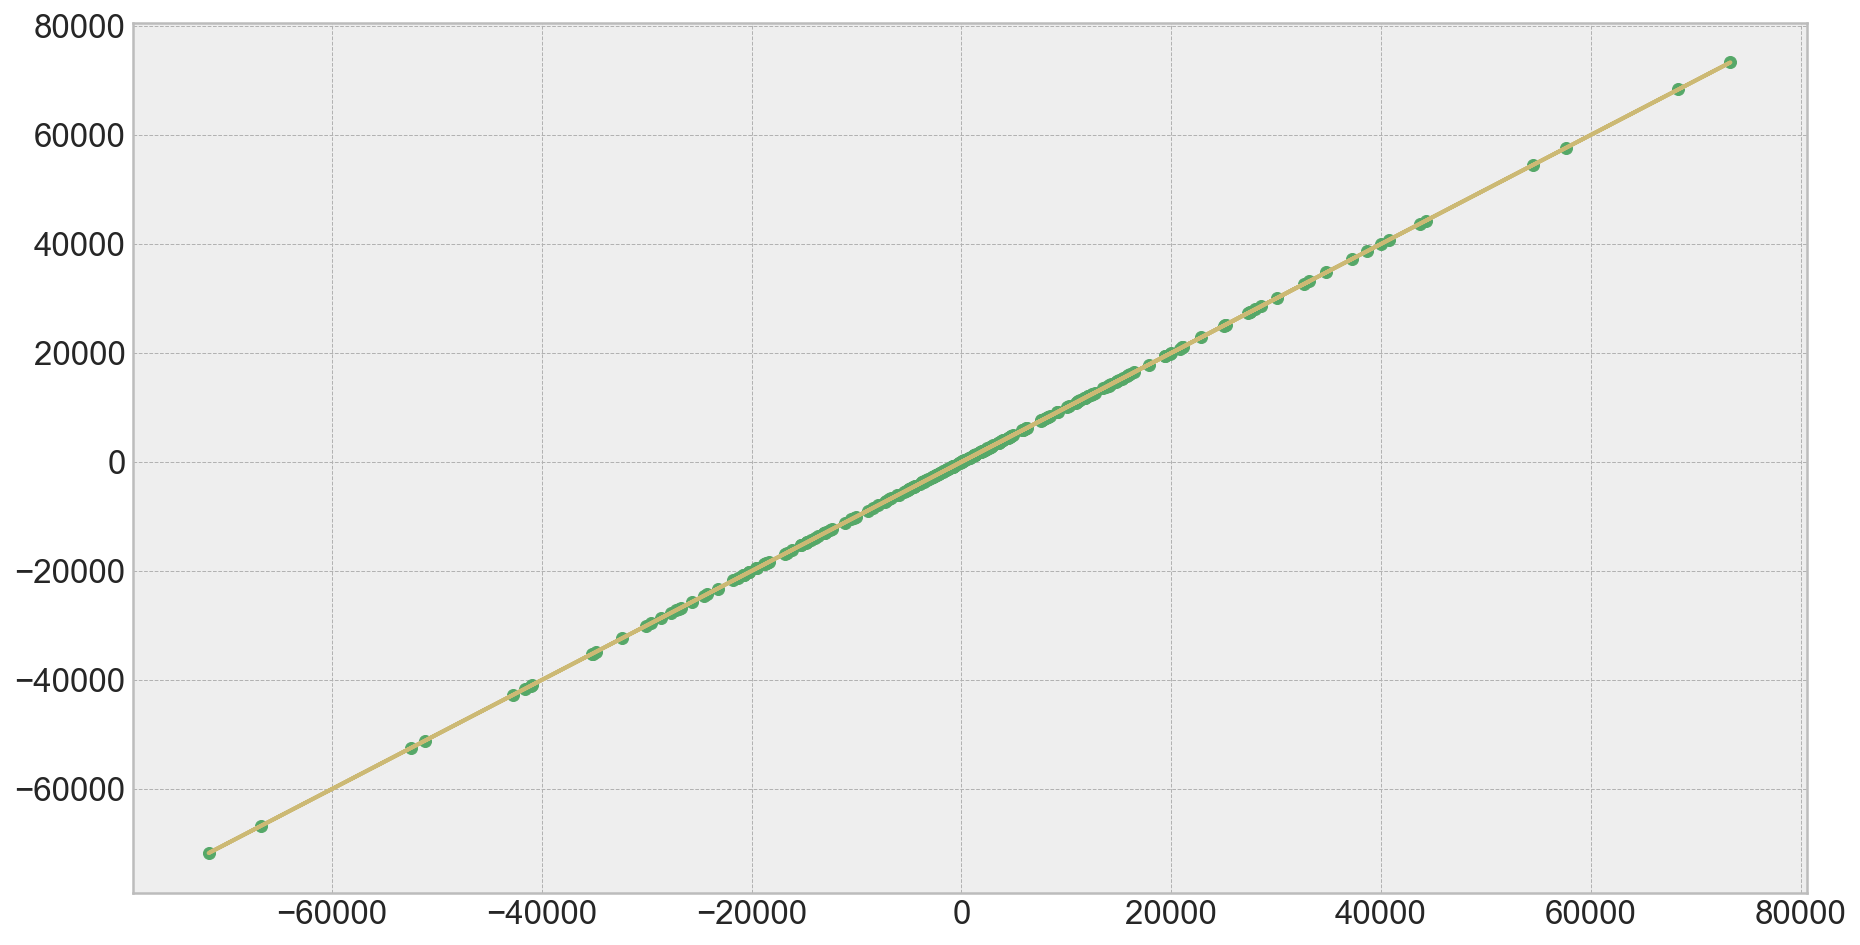

In [35]:
# plot residuals
df = awards_by_week_5y.copy()
fig, ax = plt.subplots(figsize=(15,8))
predictor = 'diff'
pred_values = df['diff'].values
df['y_bar'] = df['diff'].mean()
#baseline_residuals = [(i[0]-i[1]) for i in zip(df['diff'], df['y_bar'])]
#new_residuals = [(i[0]-i[1]) for i in zip(df['diff'], pred_values)]
ax.scatter(df[predictor], df['diff'], color='g')
ax.plot(df[predictor], pred_values, color='y')
ax.vlines([x for x in df[predictor]], [p for p in pred_values], [y for y in df['diff']])
plt.show();

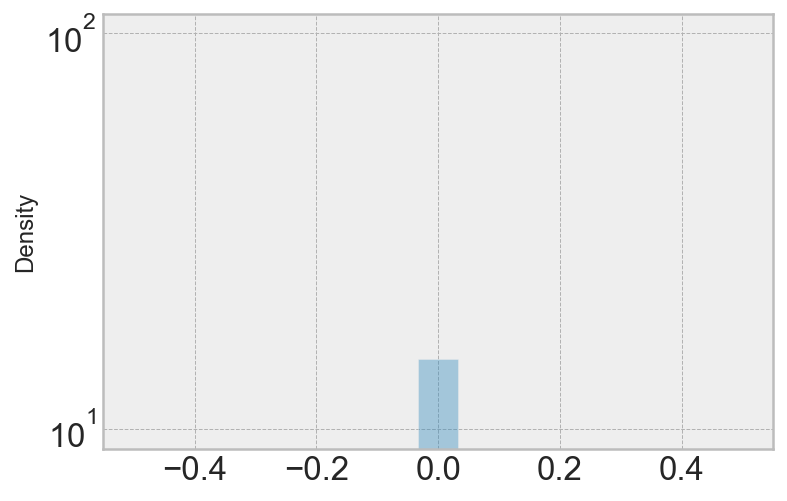

In [36]:
residuals = [i[0]-i[1] for i in zip(pred_values, df['diff'])]
sns.distplot(residuals)
plt.yscale('log')
plt.show;

In [37]:
df['residuals'] = residuals
df['pred_values'] = pred_values

In [38]:
df.residuals.map(lambda x: x**2).mean()
df.residuals.map(lambda x: x**2).mean()**0.5

0.0

0.0

In [39]:
np.allclose(sum(residuals[4:]), 0)
sum(residuals[4:])

True

0.0

There is less correlation between date and award in the last 5 years.

### 1.3.2 ACF and PACF

In [40]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tqdm import tqdm
from scipy import stats

In [41]:
def autocorr_plots(y, lags=20, alpha=0.05, figsize=(12,4)):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=figsize, sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'Autocorrelation at {lags} lag/s')

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'Partial Autocorrelation at {lags} lag/s')

    return fig, ax

In [42]:
def pandas_autocorr(y, lag=1):
    X = pd.DataFrame({'a': y, 'b': y.shift(lag)}).copy()
    X.dropna(inplace=True)
    autocorr = X.corr().iloc[0, 1]
    return X

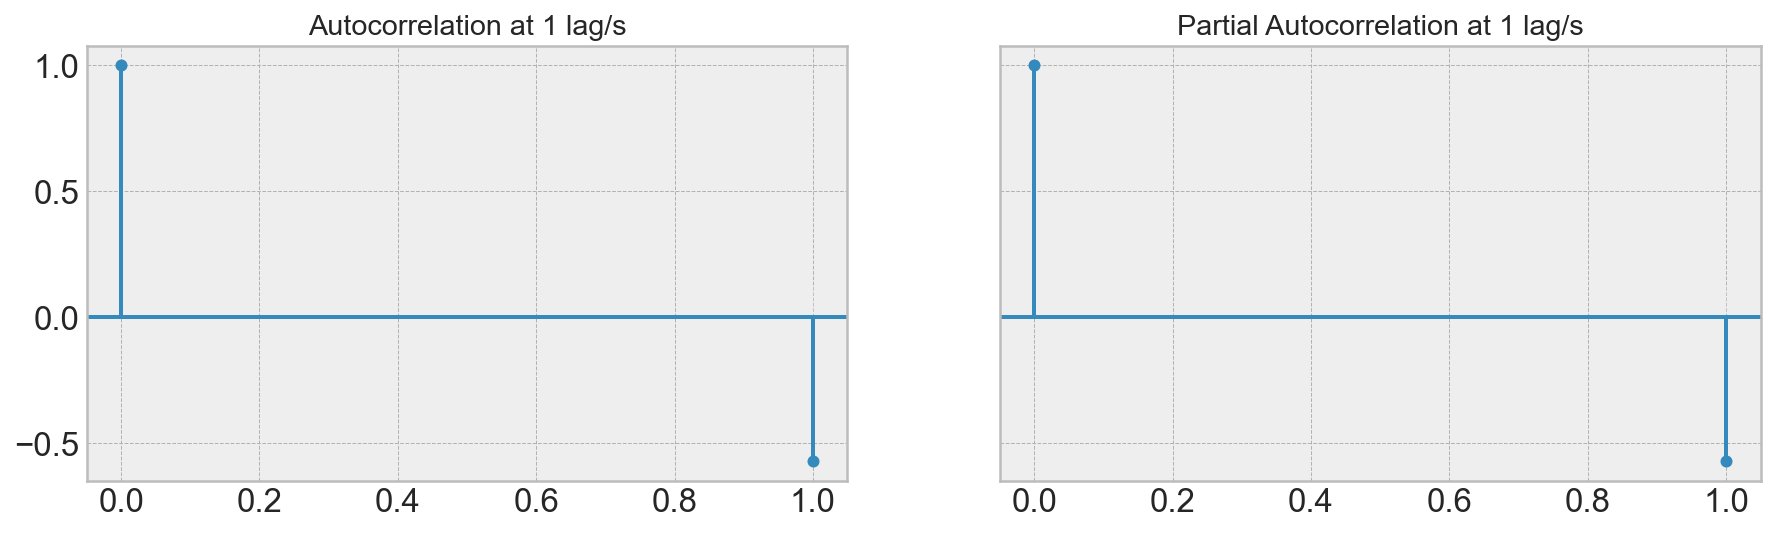

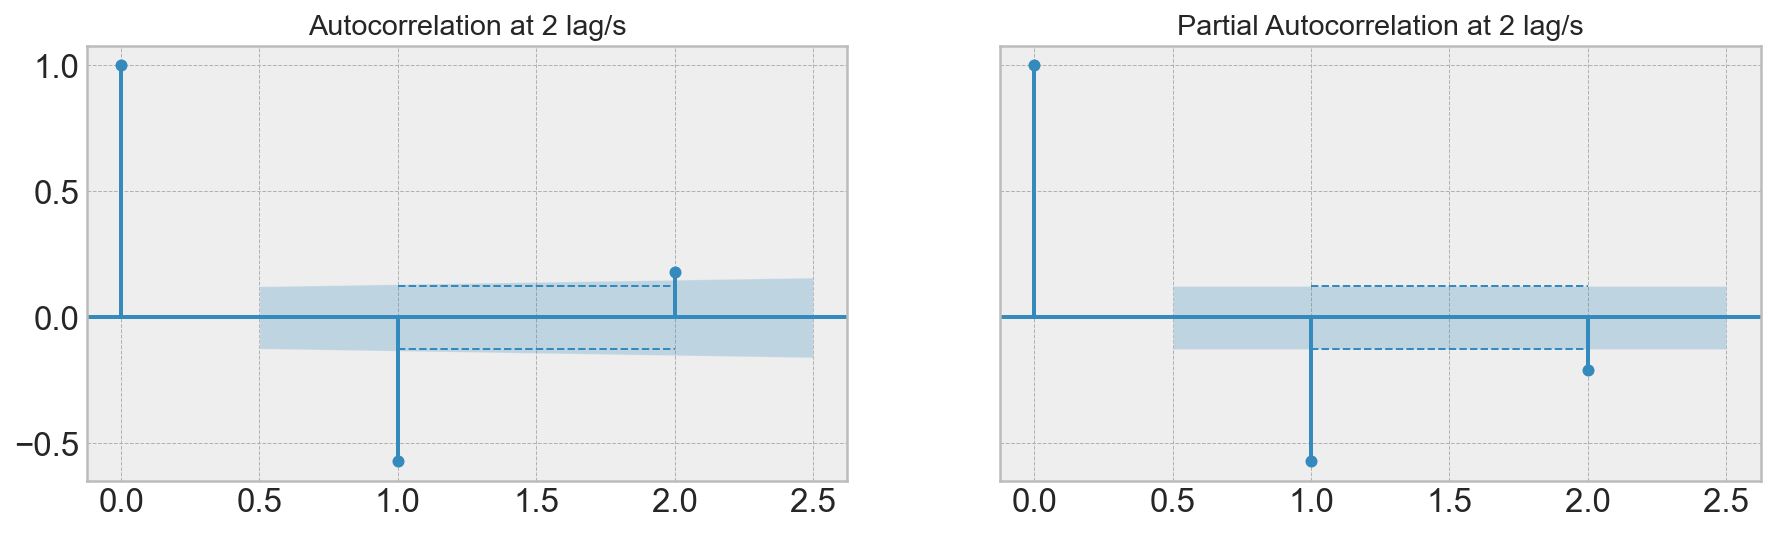

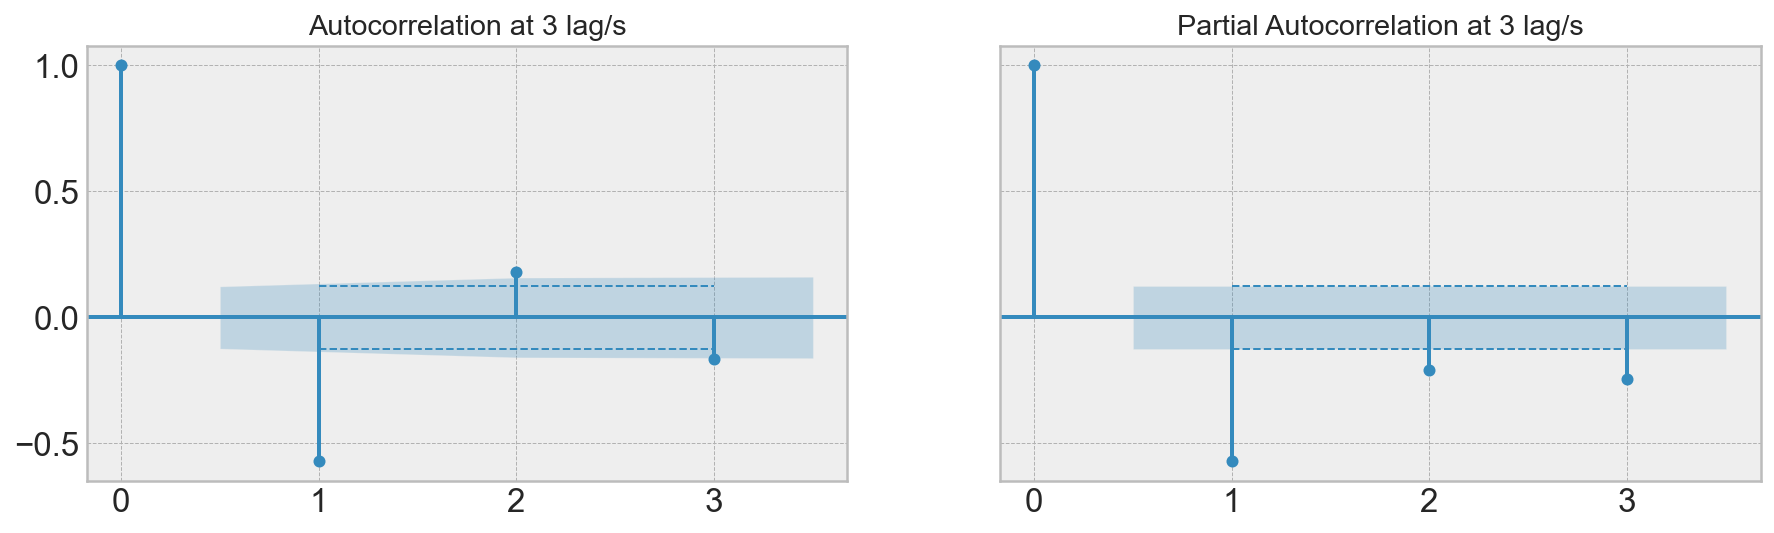

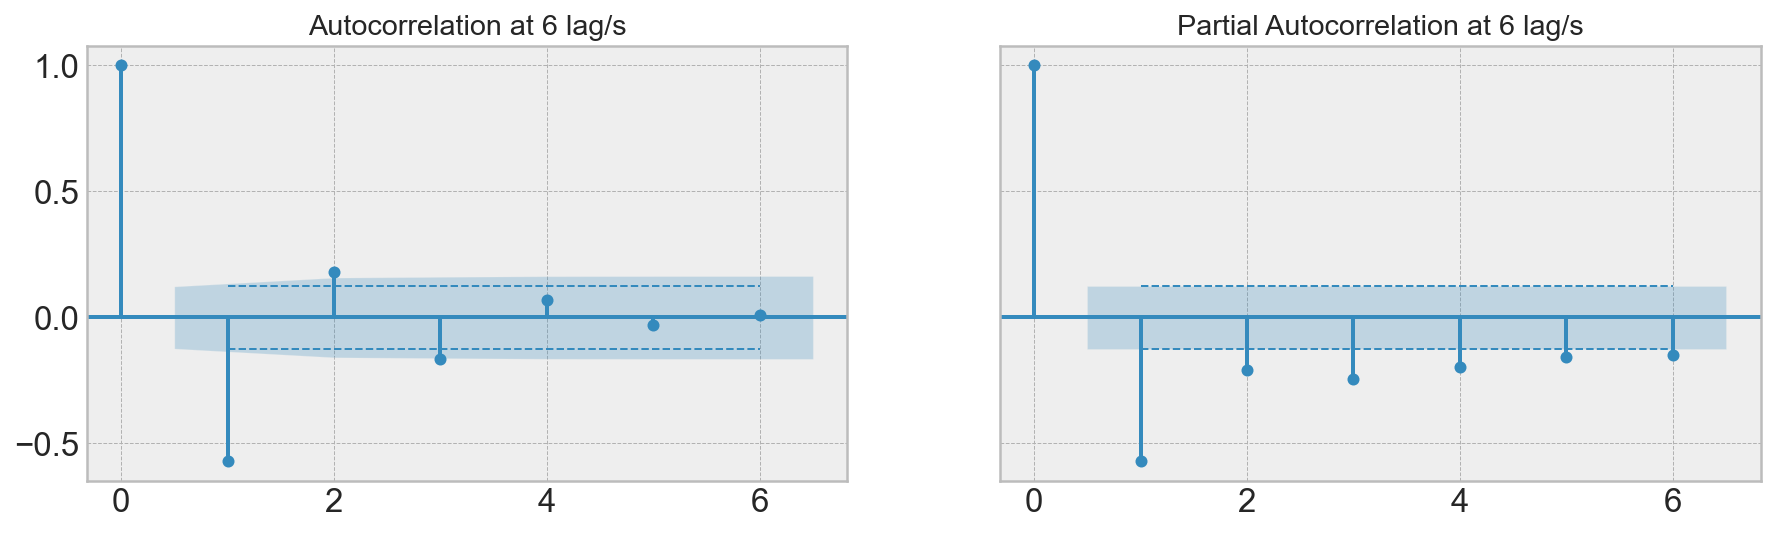

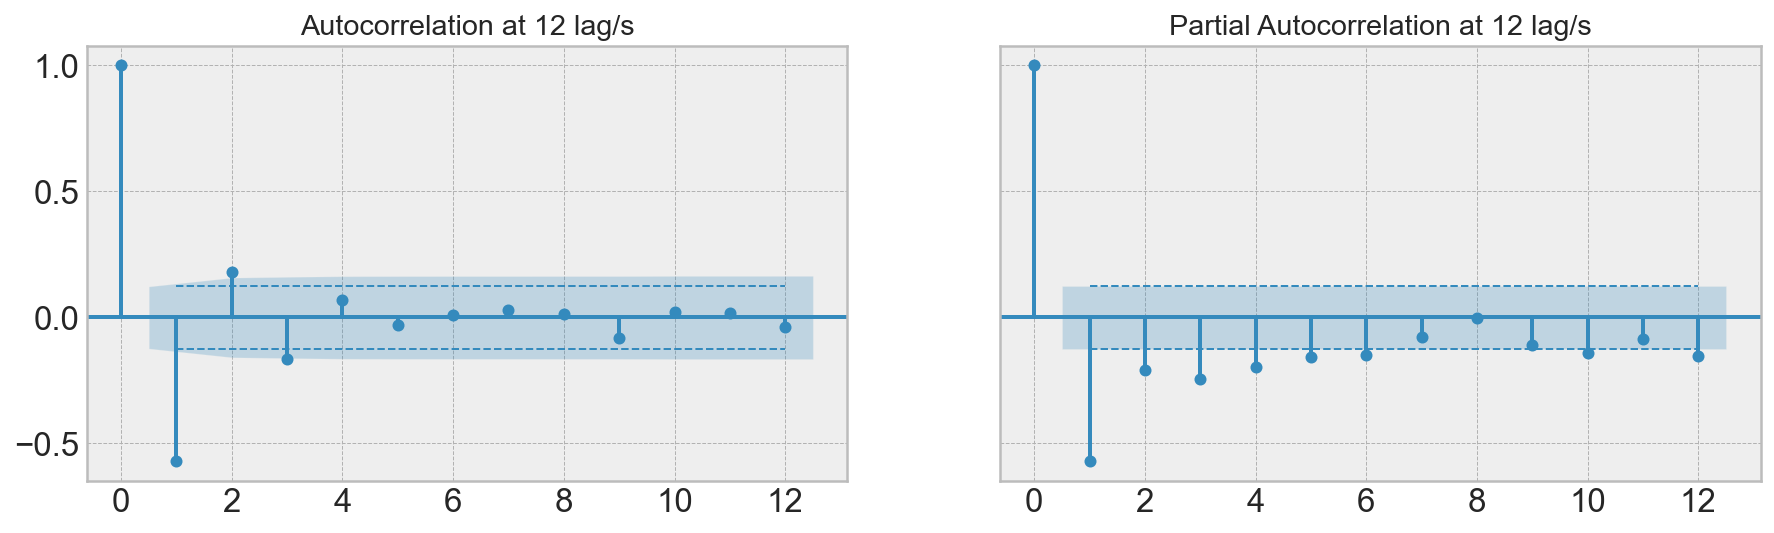

In [43]:
for i in [1, 2, 3, 6, 12]:
    fig, ax = autocorr_plots(awards_by_week_5y['diff'], lags=i, alpha=0.05, figsize=(15,4))

## 1.4 ARIMA Models

Judging by the ACF lag 1 is negatively autocorrelated by -0.5 and the PACF indicates that lags 2, 3 and 4 have some effect on the grant awarded at time 0.

We should start with a MA(1) model since PACF does tails off to 0 and PACF does not.  These are the P/ACFs for first order differenced data, so the likely model is ARIMA(0,1,1).


In [50]:
model_data = awards_by_week_5y['amount_awarded']
model = sm.tsa.statespace.SARIMAX(model_data, order=(0, 1, 1))
results = model.fit(maxiter=5000)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         amount_awarded   No. Observations:                  253
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2758.427
Date:                Thu, 03 Jun 2021   AIC                           5520.854
Time:                        10:43:40   BIC                           5527.913
Sample:                    06-19-2016   HQIC                          5523.694
                         - 04-18-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9360      0.030    -30.929      0.000      -0.995      -0.877
sigma2      1.874e+08   2.14e-11   8.75e+18      0.000    1.87e+08    1.87e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               288.07
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+35. Standard errors may be unstable.
"""

In [46]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [47]:
from itertools import combinations, permutations
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

perms = permutations(range(0,3), 2)
orders = []
for p in perms:
    for d in [1,2]:
        for t in ['n', 'c', None]:
            orders.append(p[:1]+(d,)+p[1:]+(t,))

In [51]:
ts = TimeSeriesSplit(n_splits=3)
splits = [split for split in ts.split(model_data)]
test_size = splits[0][1].shape[0]

In [52]:
cv_scores = {}
pbar = tqdm(orders)
for order in pbar:
    pbar.set_description(f"Processing {order}")
    mses = []
    for i in range(ts.n_splits):
        try:
            y_train = model_data.iloc[splits[i][0]]
            y_test = model_data.iloc[splits[i][1]]
            model_cv = sm.tsa.statespace.SARIMAX(y_train, order=order[:3], trend=order[3:][0])
            results_cv = model_cv.fit(maxiter=5000)
            pred_test = results_cv.predict(start=0, end=len(y_train)+test_size-1, dynamic=False)[-test_size:]
            mses.append(mean_squared_error(y_test, pred_test))
        except Exception as e:
            print(e)
            mses.append(np.NaN)
            continue
    cv_scores[order] = mses
    clear_output(wait=True)

Processing (2, 2, 1, None): 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]


In [53]:
df_scores = pd.DataFrame(cv_scores).T.mean(axis=1).reset_index().sort_values(0)
df_scores.columns = ['p', 'd', 'q', 't', 'cv_score']
df_scores['cv_score_sqrt'] = df_scores['cv_score']**0.5
df_scores.head(5)

p  d  q    t      cv_score  cv_score_sqrt
20  1  1  2  NaN  1.674322e+08   12939.558861
18  1  1  2    n  1.674322e+08   12939.558861
32  2  1  1  NaN  1.674382e+08   12939.790129
30  2  1  1    n  1.674382e+08   12939.790129
2   0  1  1  NaN  1.675826e+08   12945.368672

The best scoring is 0th-order autoregressive, 1st-order differentiated and 1st-order moving average.

In [55]:
model_data = awards_by_week_5y['amount_awarded']
model = sm.tsa.statespace.SARIMAX(model_data, order=(0, 1, 1))
results = model.fit(maxiter=5000)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         amount_awarded   No. Observations:                  253
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2758.427
Date:                Thu, 03 Jun 2021   AIC                           5520.854
Time:                        10:44:02   BIC                           5527.913
Sample:                    06-19-2016   HQIC                          5523.694
                         - 04-18-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9360      0.030    -30.929      0.000      -0.995      -0.877
sigma2      1.874e+08   2.14e-11   8.75e+18      0.000    1.87e+08    1.87e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               288.07
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+35. Standard errors may be unstable.
"""

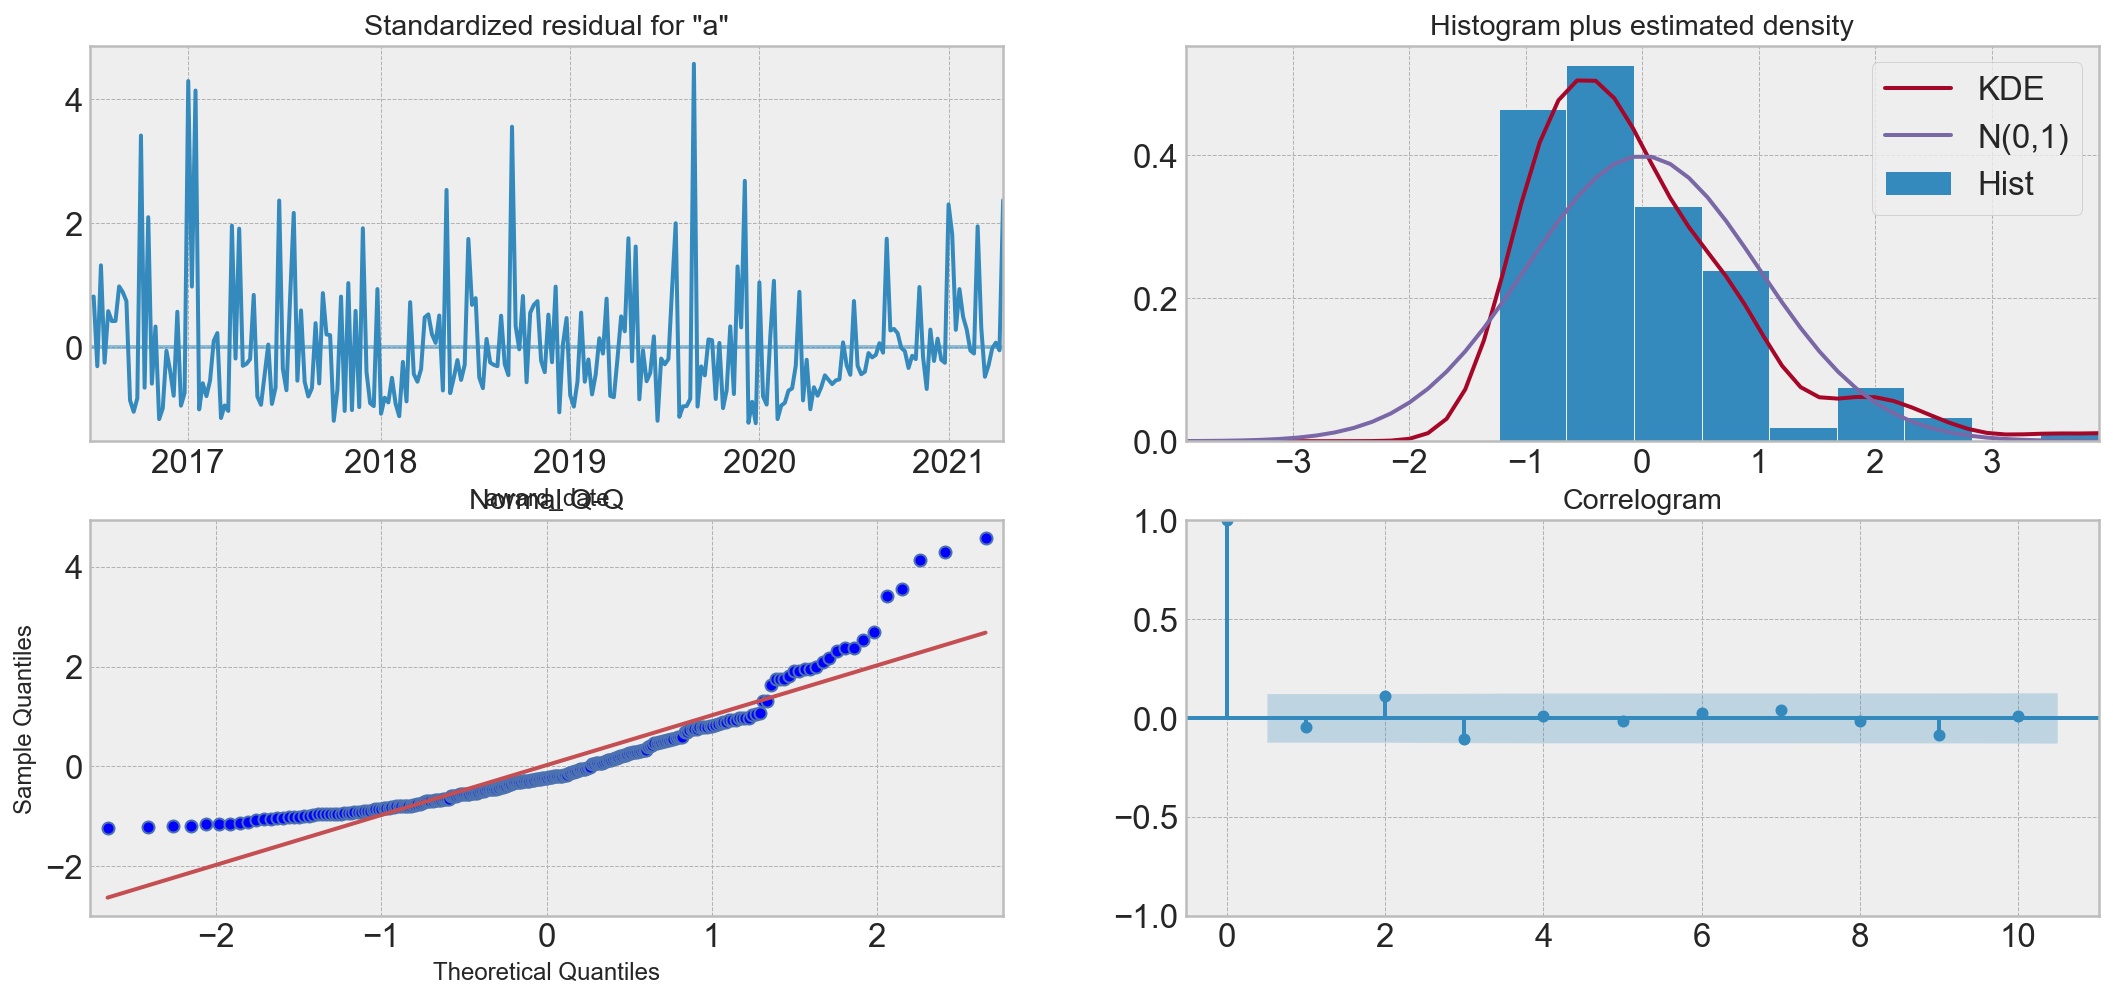

In [51]:
results.plot_diagnostics(figsize=(18, 8))
plt.show();

## 1.5 Forecasting

Start date points from 2018-12-30 00:00:00
start dynamic forecasting from 2019-12-29 00:00:00


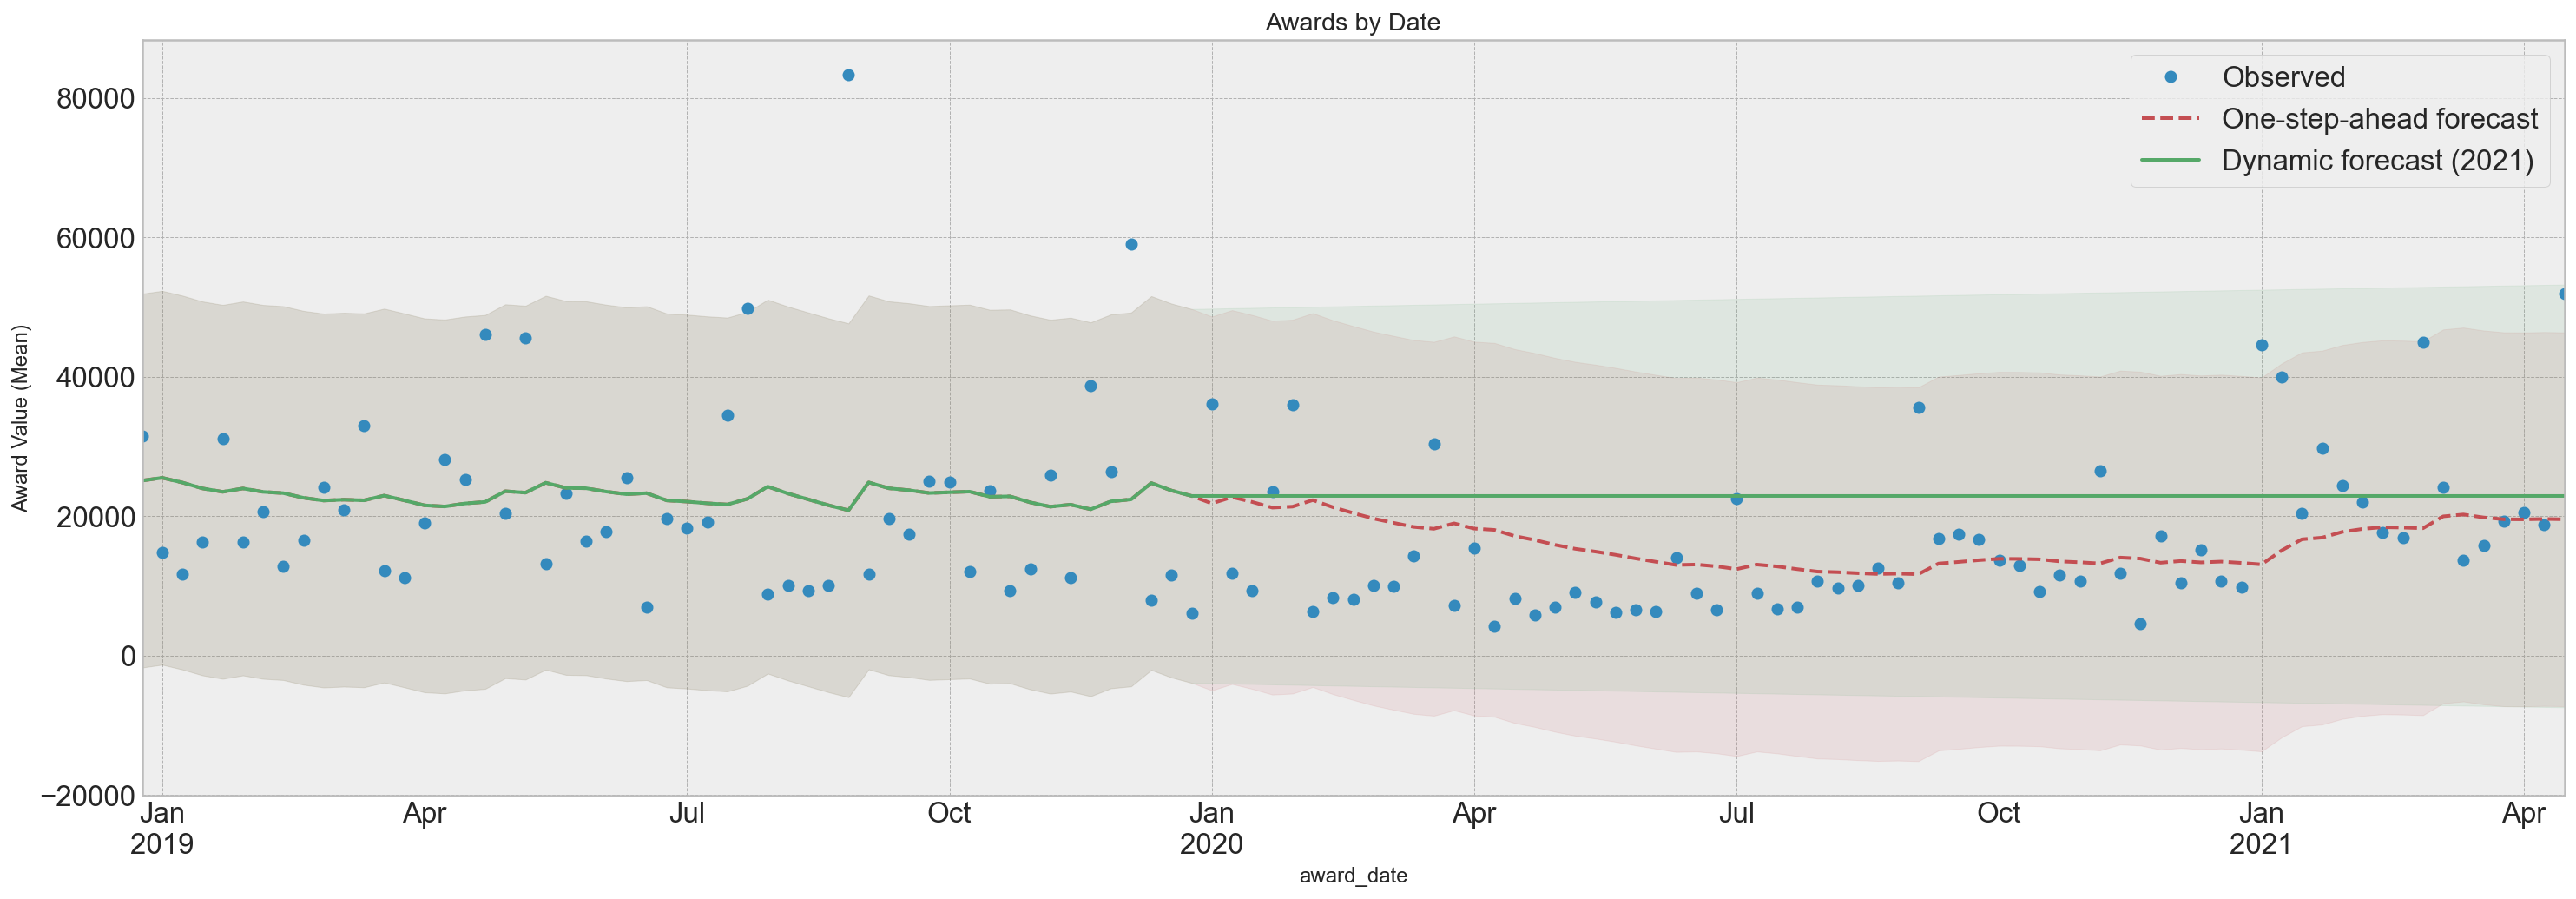

In [57]:
# predictions
predict = results.get_prediction()
predict_ci = predict.conf_int()

def nearest(items: Iterable, pivot: Any) -> Any:
    """Returns nearest item to specified item"""
    return min(items, key=lambda x: abs(x - pivot))

# dynamic predictions
start_date = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
start_date = nearest(model_data.index, start_date)
forecast_date = pd.to_datetime(start_date+relativedelta(months=12))
#forecast_date = datetime.datetime.strptime('2021-01-01', '%Y-%m-%d')
forecast_date = nearest(model_data.index, forecast_date)
print(f"Start date points from {start_date}\nstart dynamic forecasting from {forecast_date}")
predict_dy = results.get_prediction(dynamic=forecast_date)
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(25,8))
npre = 4
ax.set(title='Awards by Date', xlabel='Date', ylabel='Award Value (Mean)')

# Plot data points
start_date_chart = start_date#-relativedelta(years=1)
model_data.loc[start_date_chart:].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc[start_date_chart:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[start_date_chart:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc[start_date_chart:].plot(ax=ax, style='g', label='Dynamic forecast (2021)')
ci = predict_dy_ci.loc[start_date_chart:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

# save
plt.savefig(pj(reports_dir,'time_series_5y_forecast'), format="png")
legend = ax.legend(loc='upper right')
plt.show();

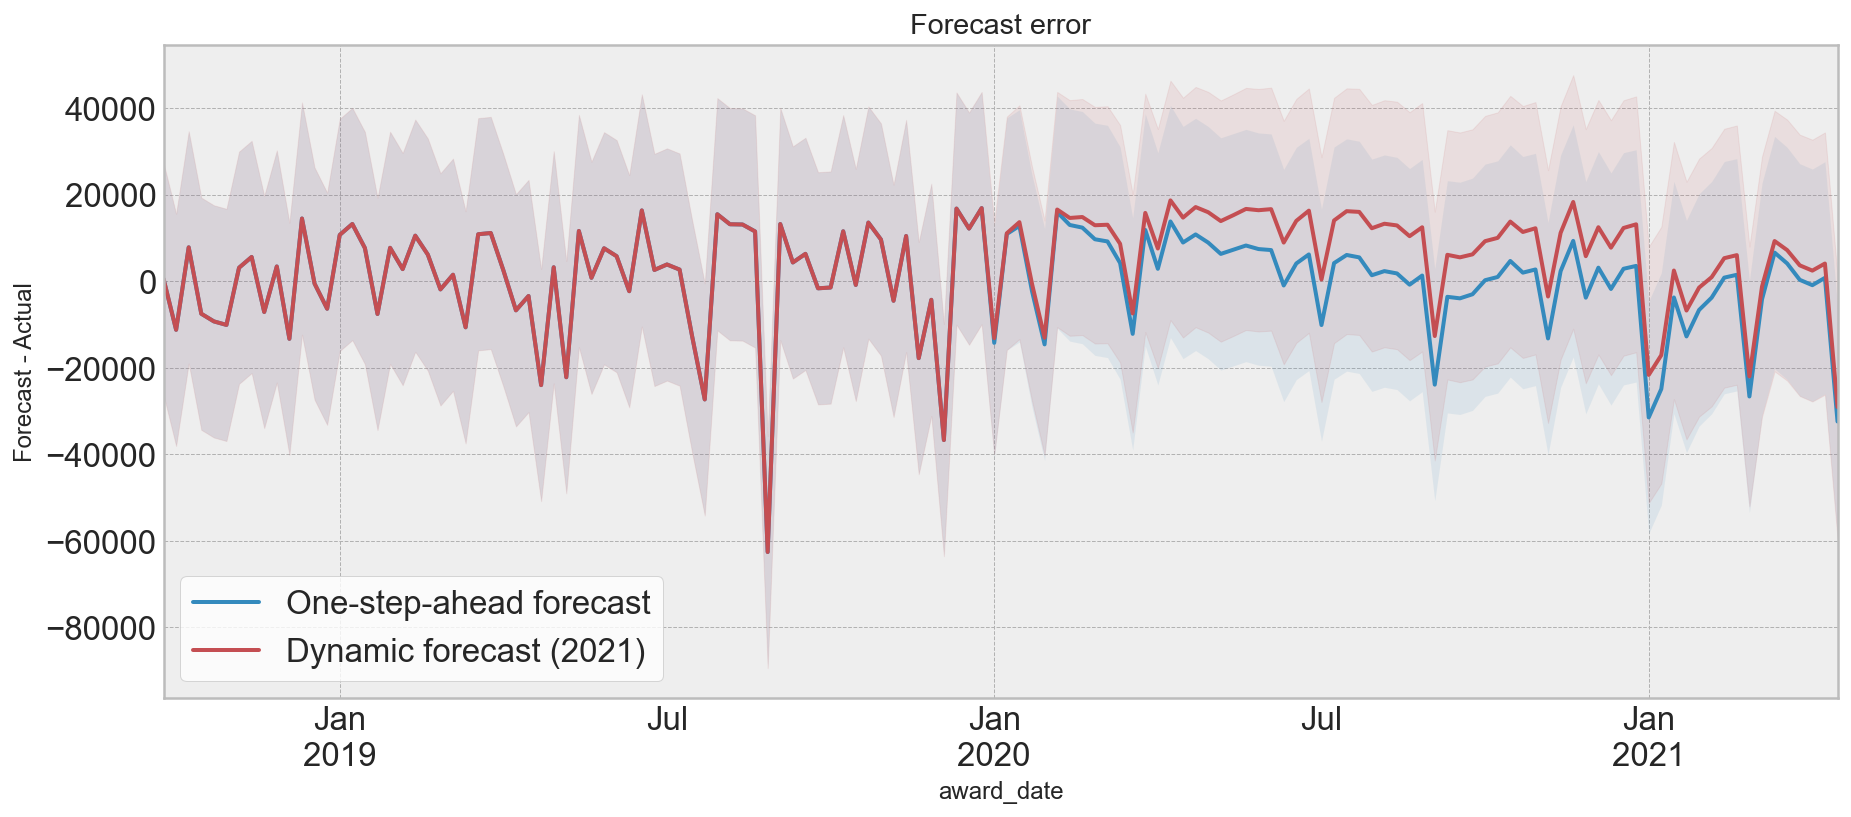

The Mean Squared Error is 155425558.12
The Root Mean Squared Error is 12466.98


In [58]:
# Prediction error

X = model_data.index
y = model_data

# Graph
fig, ax = plt.subplots(figsize=(15,6))
npre = 4
ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - y
start_date_chart = start_date-relativedelta(months=3)
predict_error.loc[start_date_chart:].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc[start_date_chart:].copy()
ci.iloc[:,0] -= y.loc[start_date_chart:]
ci.iloc[:,1] -= y.loc[start_date_chart:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - y
predict_dy_error.loc[start_date_chart:].plot(ax=ax, style='r', label='Dynamic forecast (2021)')
ci = predict_dy_ci.loc[start_date_chart:].copy()
ci.iloc[:,0] -= y.loc[start_date_chart:]
ci.iloc[:,1] -= y.loc[start_date_chart:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')
plt.show();

y_forecasted = predict.predicted_mean
y_truth = y[start_date:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error is {round(mse, 2)}')
print(f'The Root Mean Squared Error is {round(np.sqrt(mse), 2)}')

plt.show();

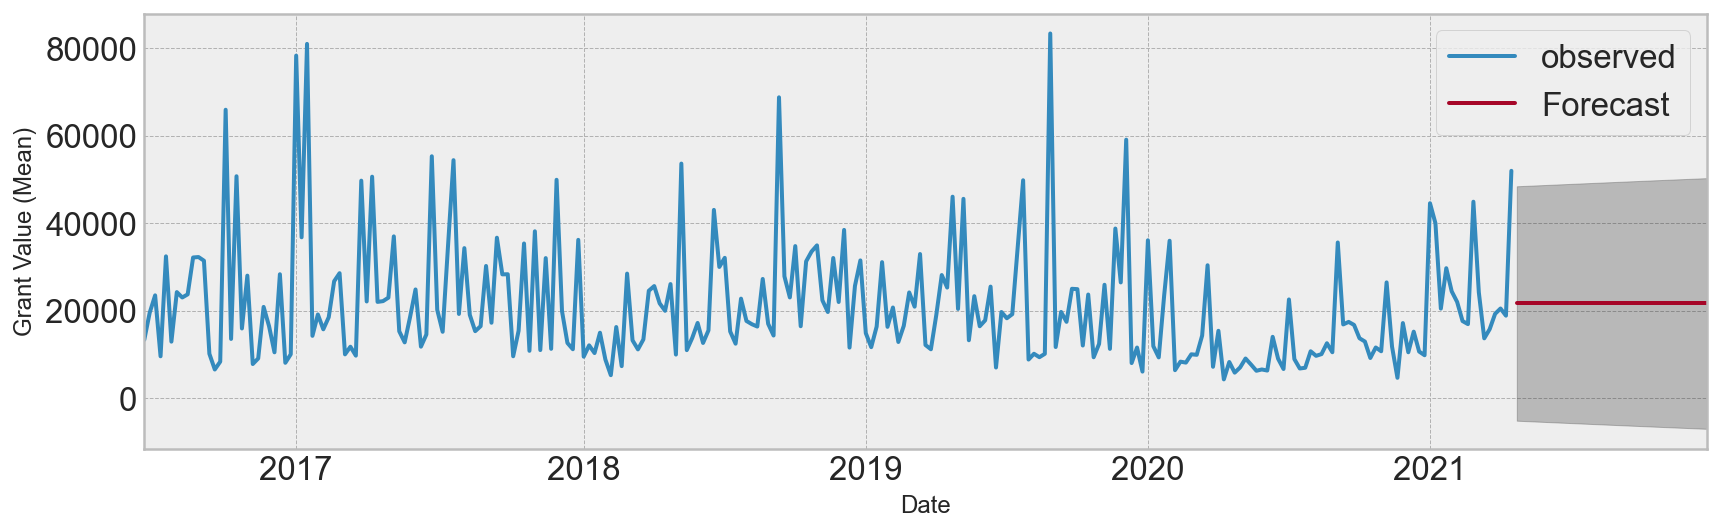

In [60]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Grant Value (Mean)')
plt.legend()
plt.show();

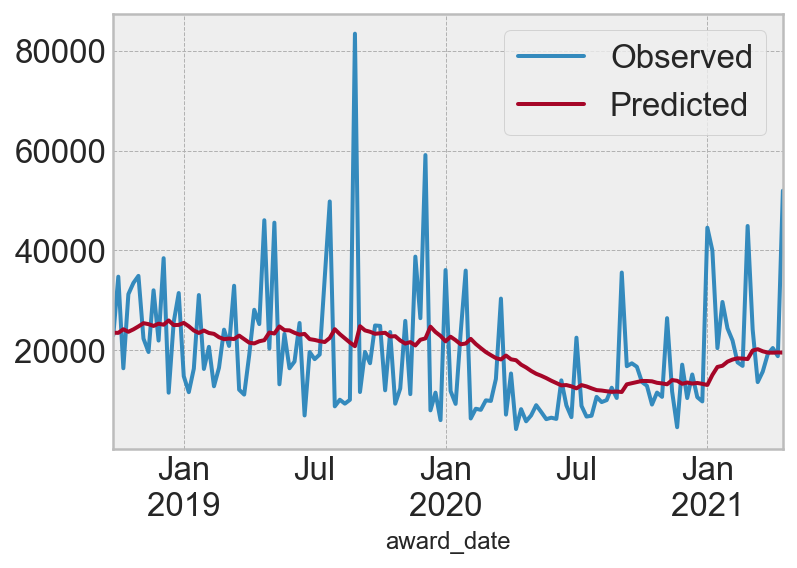

In [61]:
model_data.loc[start_date_chart:].plot(label='Observed')
predict.predicted_mean.loc[start_date_chart:].plot(label='Predicted')
plt.legend()
plt.show();

In [62]:
forecast = pred_uc.predicted_mean
forecast.head(12)

2021-04-25    21618.167969
2021-05-02    21618.167969
2021-05-09    21618.167969
2021-05-16    21618.167969
2021-05-23    21618.167969
2021-05-30    21618.167969
2021-06-06    21618.167969
2021-06-13    21618.167969
2021-06-20    21618.167969
2021-06-27    21618.167969
2021-07-04    21618.167969
2021-07-11    21618.167969
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [112]:
pred_ci.head(12)

lower amount_awarded  upper amount_awarded
2021-04-25          -5210.019778          48446.355717
2021-05-02          -5264.899345          48501.235283
2021-05-09          -5319.667107          48556.003046
2021-05-16          -5374.323745          48610.659684
2021-05-23          -5428.869934          48665.205873
2021-05-30          -5483.306340          48719.642279
2021-06-06          -5537.633623          48773.969561
2021-06-13          -5591.852437          48828.188375
2021-06-20          -5645.963428          48882.299367
2021-06-27          -5699.967239          48936.303178
2021-07-04          -5753.864502          48990.200441
2021-07-11          -5807.655847          49043.991786

#### Reduce to 10k grants

Does this make predictions better?

In [63]:
# reduce to 10k grants and under
model_data_10k = data[data['amount_awarded']<=10000]

In [74]:
# resample by week
df = model_data_10k.groupby('award_date')['amount_awarded'].median().reset_index()
df['award_date'] = pd.to_datetime(df['award_date'])
years_ago = datetime.datetime.now() - relativedelta(years=5)
df = df[df['award_date']>=years_ago]
df = df.set_index('award_date',drop=True)
df = pd.DataFrame(df.resample('W').mean() ,columns=['amount_awarded'])
df['diff'] = df['amount_awarded'].diff()
df = df.iloc[1:,:]
model_data_10k = df['amount_awarded']

In [76]:
ts = TimeSeriesSplit(n_splits=3)
splits = [split for split in ts.split(model_data_10k)]
test_size = splits[0][1].shape[0]

In [77]:
cv_scores = {}
pbar = tqdm(orders)
for order in pbar:
    pbar.set_description(f"Processing {order}")
    mses = []
    for i in range(ts.n_splits):
        try:
            y_train = model_data_10k.iloc[splits[i][0]]
            y_test = model_data_10k.iloc[splits[i][1]]
            model_cv = sm.tsa.statespace.SARIMAX(y_train, order=order[:3], trend=order[3:][0])
            results_cv = model_cv.fit(maxiter=5000)
            pred_test = results_cv.predict(start=0, end=len(y_train)+test_size-1, dynamic=False)[-test_size:]
            mses.append(mean_squared_error(y_test, pred_test))
        except Exception as e:
            print(e)
            mses.append(np.NaN)
            continue
    cv_scores[order] = mses
    clear_output(wait=True)

Processing (2, 2, 1, None): 100%|██████████| 36/36 [00:08<00:00,  4.05it/s]


In [79]:
df_scores_10k = pd.DataFrame(cv_scores).T.mean(axis=1).reset_index().sort_values(0)
df_scores_10k.columns = ['p', 'd', 'q', 't', 'cv_score']
df_scores_10k['cv_score_sqrt'] = df_scores_10k['cv_score']**0.5
df_scores_10k.head(5)

p  d  q    t      cv_score  cv_score_sqrt
23  1  2  2  NaN  1.549949e+06    1244.969444
21  1  2  2    n  1.549949e+06    1244.969444
19  1  1  2    c  1.550757e+06    1245.293819
0   0  1  1    n  1.552233e+06    1245.886435
2   0  1  1  NaN  1.552233e+06    1245.886435

In [100]:
model_10k = sm.tsa.statespace.SARIMAX(model_data_10k, order=(1, 2, 2))
results_10k = model_10k.fit(maxiter=5000)
results_10k.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         amount_awarded   No. Observations:                  251
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -2120.478
Date:                Thu, 03 Jun 2021   AIC                           4248.956
Time:                        10:55:09   BIC                           4263.026
Sample:                    07-03-2016   HQIC                          4254.620
                         - 04-18-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1559      0.065      2.408      0.016       0.029       0.283
ma.L1         -1.9235      0.099    -19.419      0.000      -2.118      -1.729
ma.L2          0.9235      0.092     10.040      0.000       0.743       1.104
sigma2      1.363e+06   1.35e-07   1.01e+13      0.000    1.36e+06    1.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 3.76
Prob(Q):                              0.72   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                             0.28
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.22e+27. Standard errors may be unstable.
"""

Start date points from 2018-12-30 00:00:00
start dynamic forecasting from 2020-12-27 00:00:00


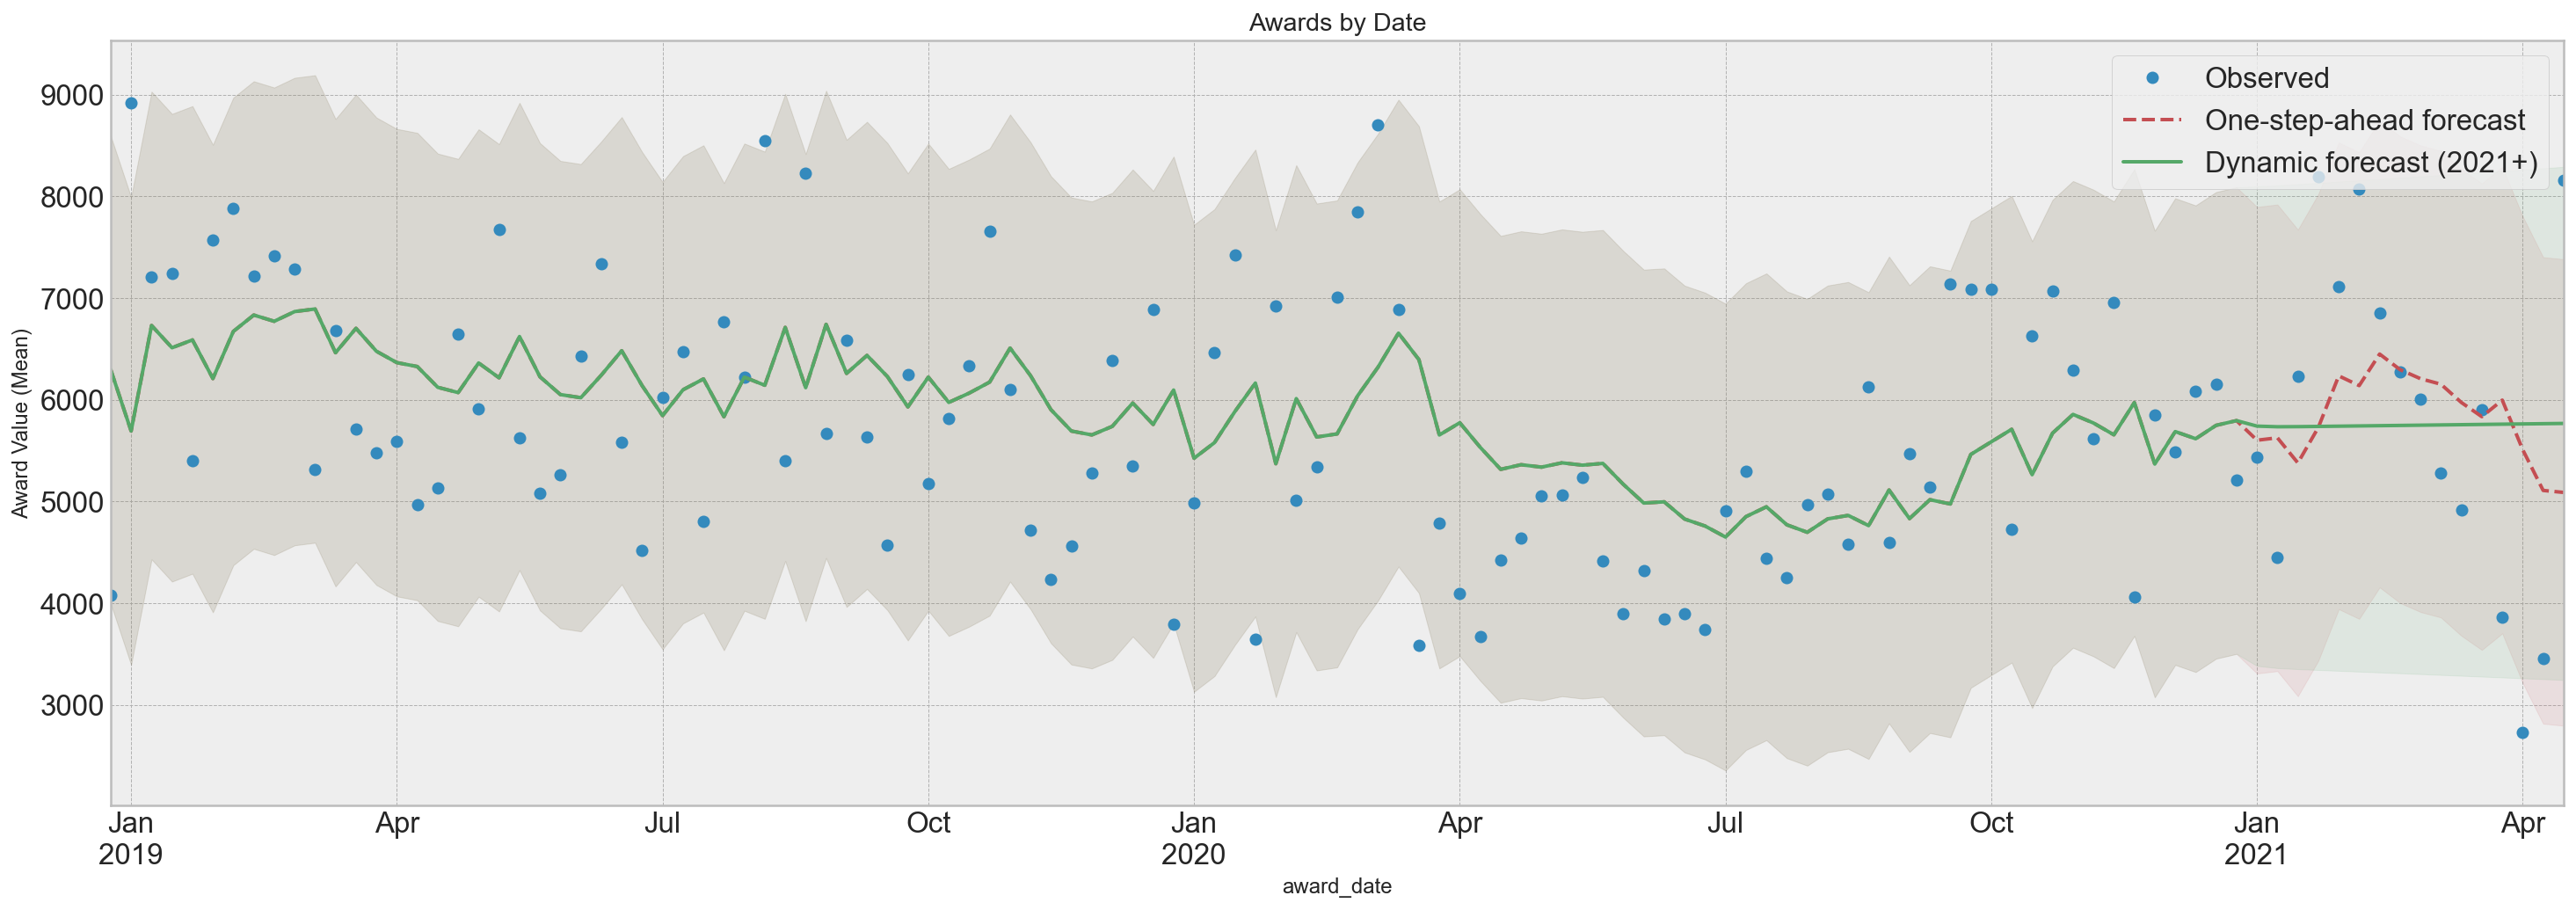

In [109]:
# predictions
predict_10k = results_10k.get_prediction()
predict_ci_10k = predict_10k.conf_int()

def nearest(items: Iterable, pivot: Any) -> Any:
    """Returns nearest item to specified item"""
    return min(items, key=lambda x: abs(x - pivot))

# dynamic predictions
start_date = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
start_date = nearest(model_data_10k.index, start_date)
forecast_date = pd.to_datetime(start_date+relativedelta(months=24))
#forecast_date = datetime.datetime.strptime('2021-01-01', '%Y-%m-%d')
forecast_date = nearest(model_data_10k.index, forecast_date)
print(f"Start date points from {start_date}\nstart dynamic forecasting from {forecast_date}")
predict_dy_10k = results_10k.get_prediction(dynamic=forecast_date)
predict_dy_ci_10k = predict_dy_10k.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(25,8))
npre = 4
ax.set(title='Awards by Date', xlabel='Date', ylabel='Award Value (Mean)')

# Plot data points
start_date_chart = start_date#-relativedelta(years=1)
model_data_10k.loc[start_date_chart:].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict_10k.predicted_mean.loc[start_date_chart:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci_10k = predict_ci_10k.loc[start_date_chart:]
ax.fill_between(ci_10k.index, ci_10k.iloc[:,0], ci_10k.iloc[:,1], color='r', alpha=0.1)
predict_dy_10k.predicted_mean.loc[start_date_chart:].plot(ax=ax, style='g', label='Dynamic forecast (2021+)')
ci_10k = predict_dy_ci_10k.loc[start_date_chart:]
ax.fill_between(ci_10k.index, ci_10k.iloc[:,0], ci_10k.iloc[:,1], color='g', alpha=0.1)

# save
plt.savefig(pj(reports_dir,'time_series_5y_forecast_10k'), format="png")
legend = ax.legend(loc='upper right')
plt.show();

In [102]:
X = model_data_10k.index
y = model_data_10k

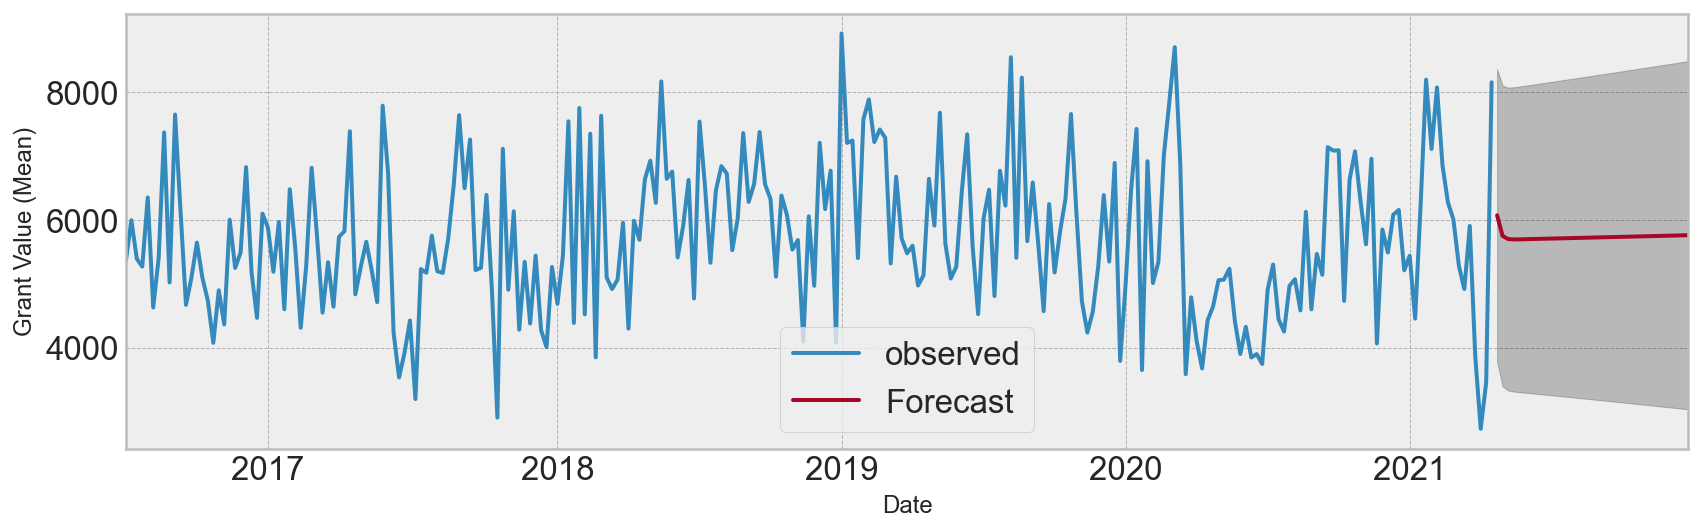

In [103]:
pred_uc_10k = results_10k.get_forecast(steps=36)
pred_ci_10k = pred_uc_10k.conf_int()
ax = y.plot(label='observed', figsize=(14, 4))
pred_uc_10k.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci_10k.index,
                pred_ci_10k.iloc[:, 0],
                pred_ci_10k.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Grant Value (Mean)')
plt.legend()
plt.show();

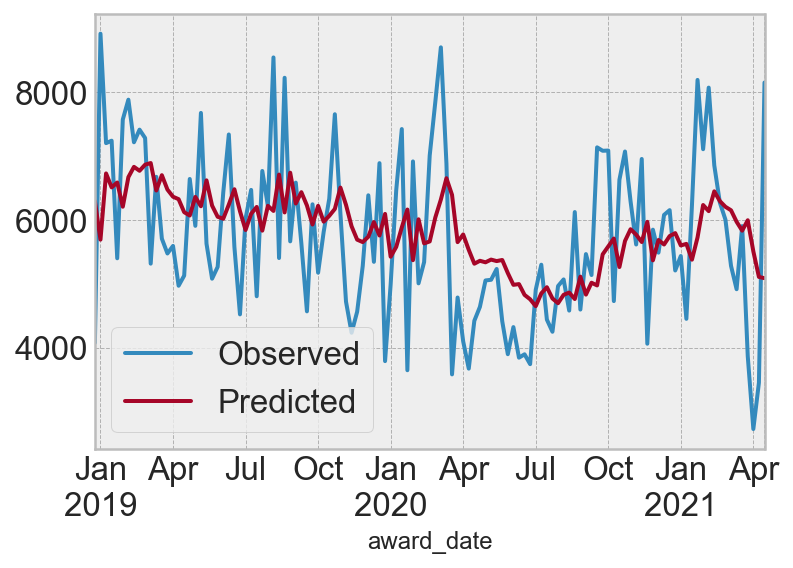

In [104]:
model_data_10k.loc[start_date_chart:].plot(label='Observed')
predict_10k.predicted_mean.loc[start_date_chart:].plot(label='Predicted')
plt.legend()
plt.show();

In [108]:
forecast_10k = pred_uc_10k.predicted_mean
forecast_10k.head(12)

2021-04-25    6071.492455
2021-05-02    5748.386659
2021-05-09    5699.778098
2021-05-16    5693.971546
2021-05-23    5694.839057
2021-05-30    5696.747247
2021-06-06    5698.817709
2021-06-13    5700.913473
2021-06-20    5703.013183
2021-06-27    5705.113508
2021-07-04    5707.213929
2021-07-11    5709.314365
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [113]:
pred_ci_10k.head(12)

lower amount_awarded  upper amount_awarded
2021-04-25           3778.035587           8364.949323
2021-05-02           3391.538839           8105.234479
2021-05-09           3327.448955           8072.107240
2021-05-16           3310.635130           8077.307961
2021-05-23           3301.093077           8088.585037
2021-05-30           3292.654007           8100.840487
2021-06-06           3284.358073           8113.277344
2021-06-13           3276.056019           8125.770928
2021-06-20           3267.724937           8138.301429
2021-06-27           3259.361614           8150.865402
2021-07-04           3250.965903           8163.461955
2021-07-11           3242.538132           8176.090598

## 1.6 Reduce data based on time series

#### 1.2.1 Mean award by year


In [114]:
data = pd.read_csv(pj(interim_dir,'grantnav_data.csv'), index_col=0)

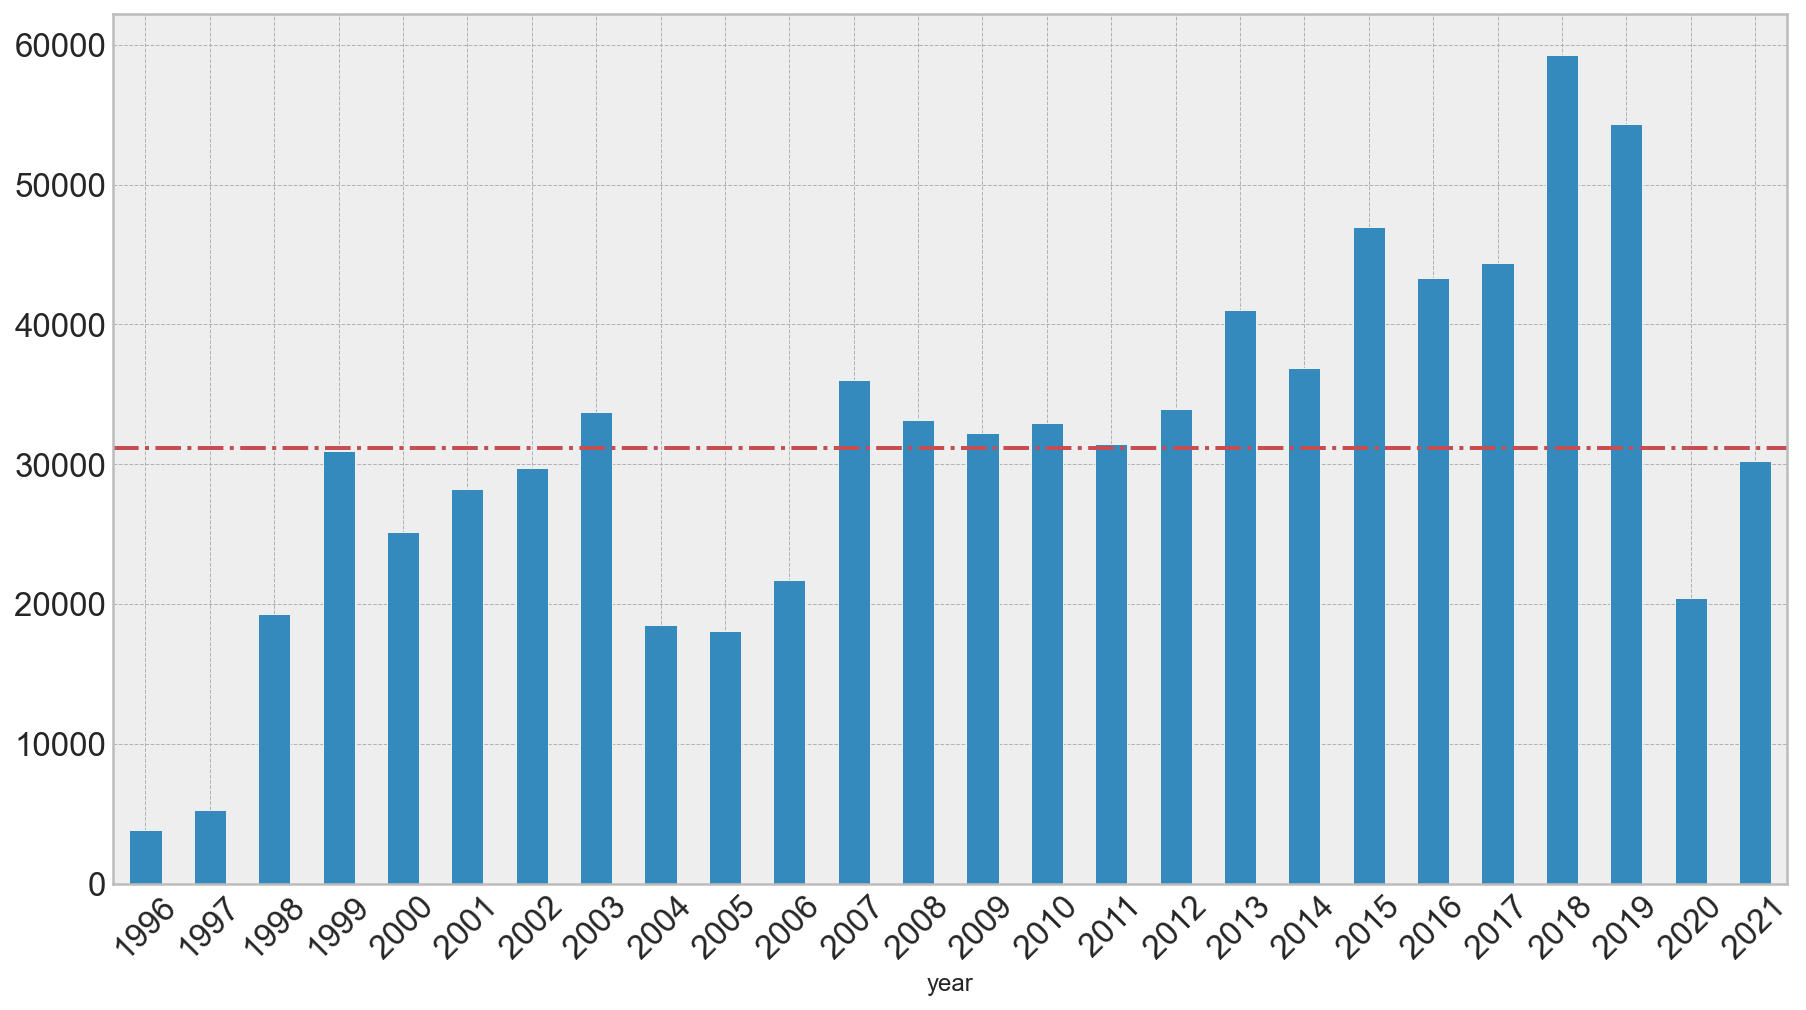

In [127]:
# mean award by year
data['award_date'] = pd.to_datetime(data['award_date'])
data['year'] = data['award_date'].dt.year
data.groupby('year')['amount_awarded'].mean().plot(kind='bar', rot=45, figsize=(15,8))
plt.axhline(data.groupby('year')['amount_awarded'].mean().mean(), color='r', linestyle='-.')
plt.show();

How does this look by different grant value bands?

#### 1.2.2 Mean award by year and quantile

In [116]:
percentile_value = 5
data['quantile_rank'] = pd.qcut(data['amount_awarded'], percentile_value,
                               labels = list(range(1, percentile_value+1)))

In [117]:
quartile_groups = pd.DataFrame(data.groupby(['year','quantile_rank'])['amount_awarded'].mean())

In [118]:
min_max_dict = {name: {'min': int(group.min()), 'max': int(group.max())} for name, group in data.groupby(['quantile_rank'])['amount_awarded']}

In [120]:
idx = pd.IndexSlice

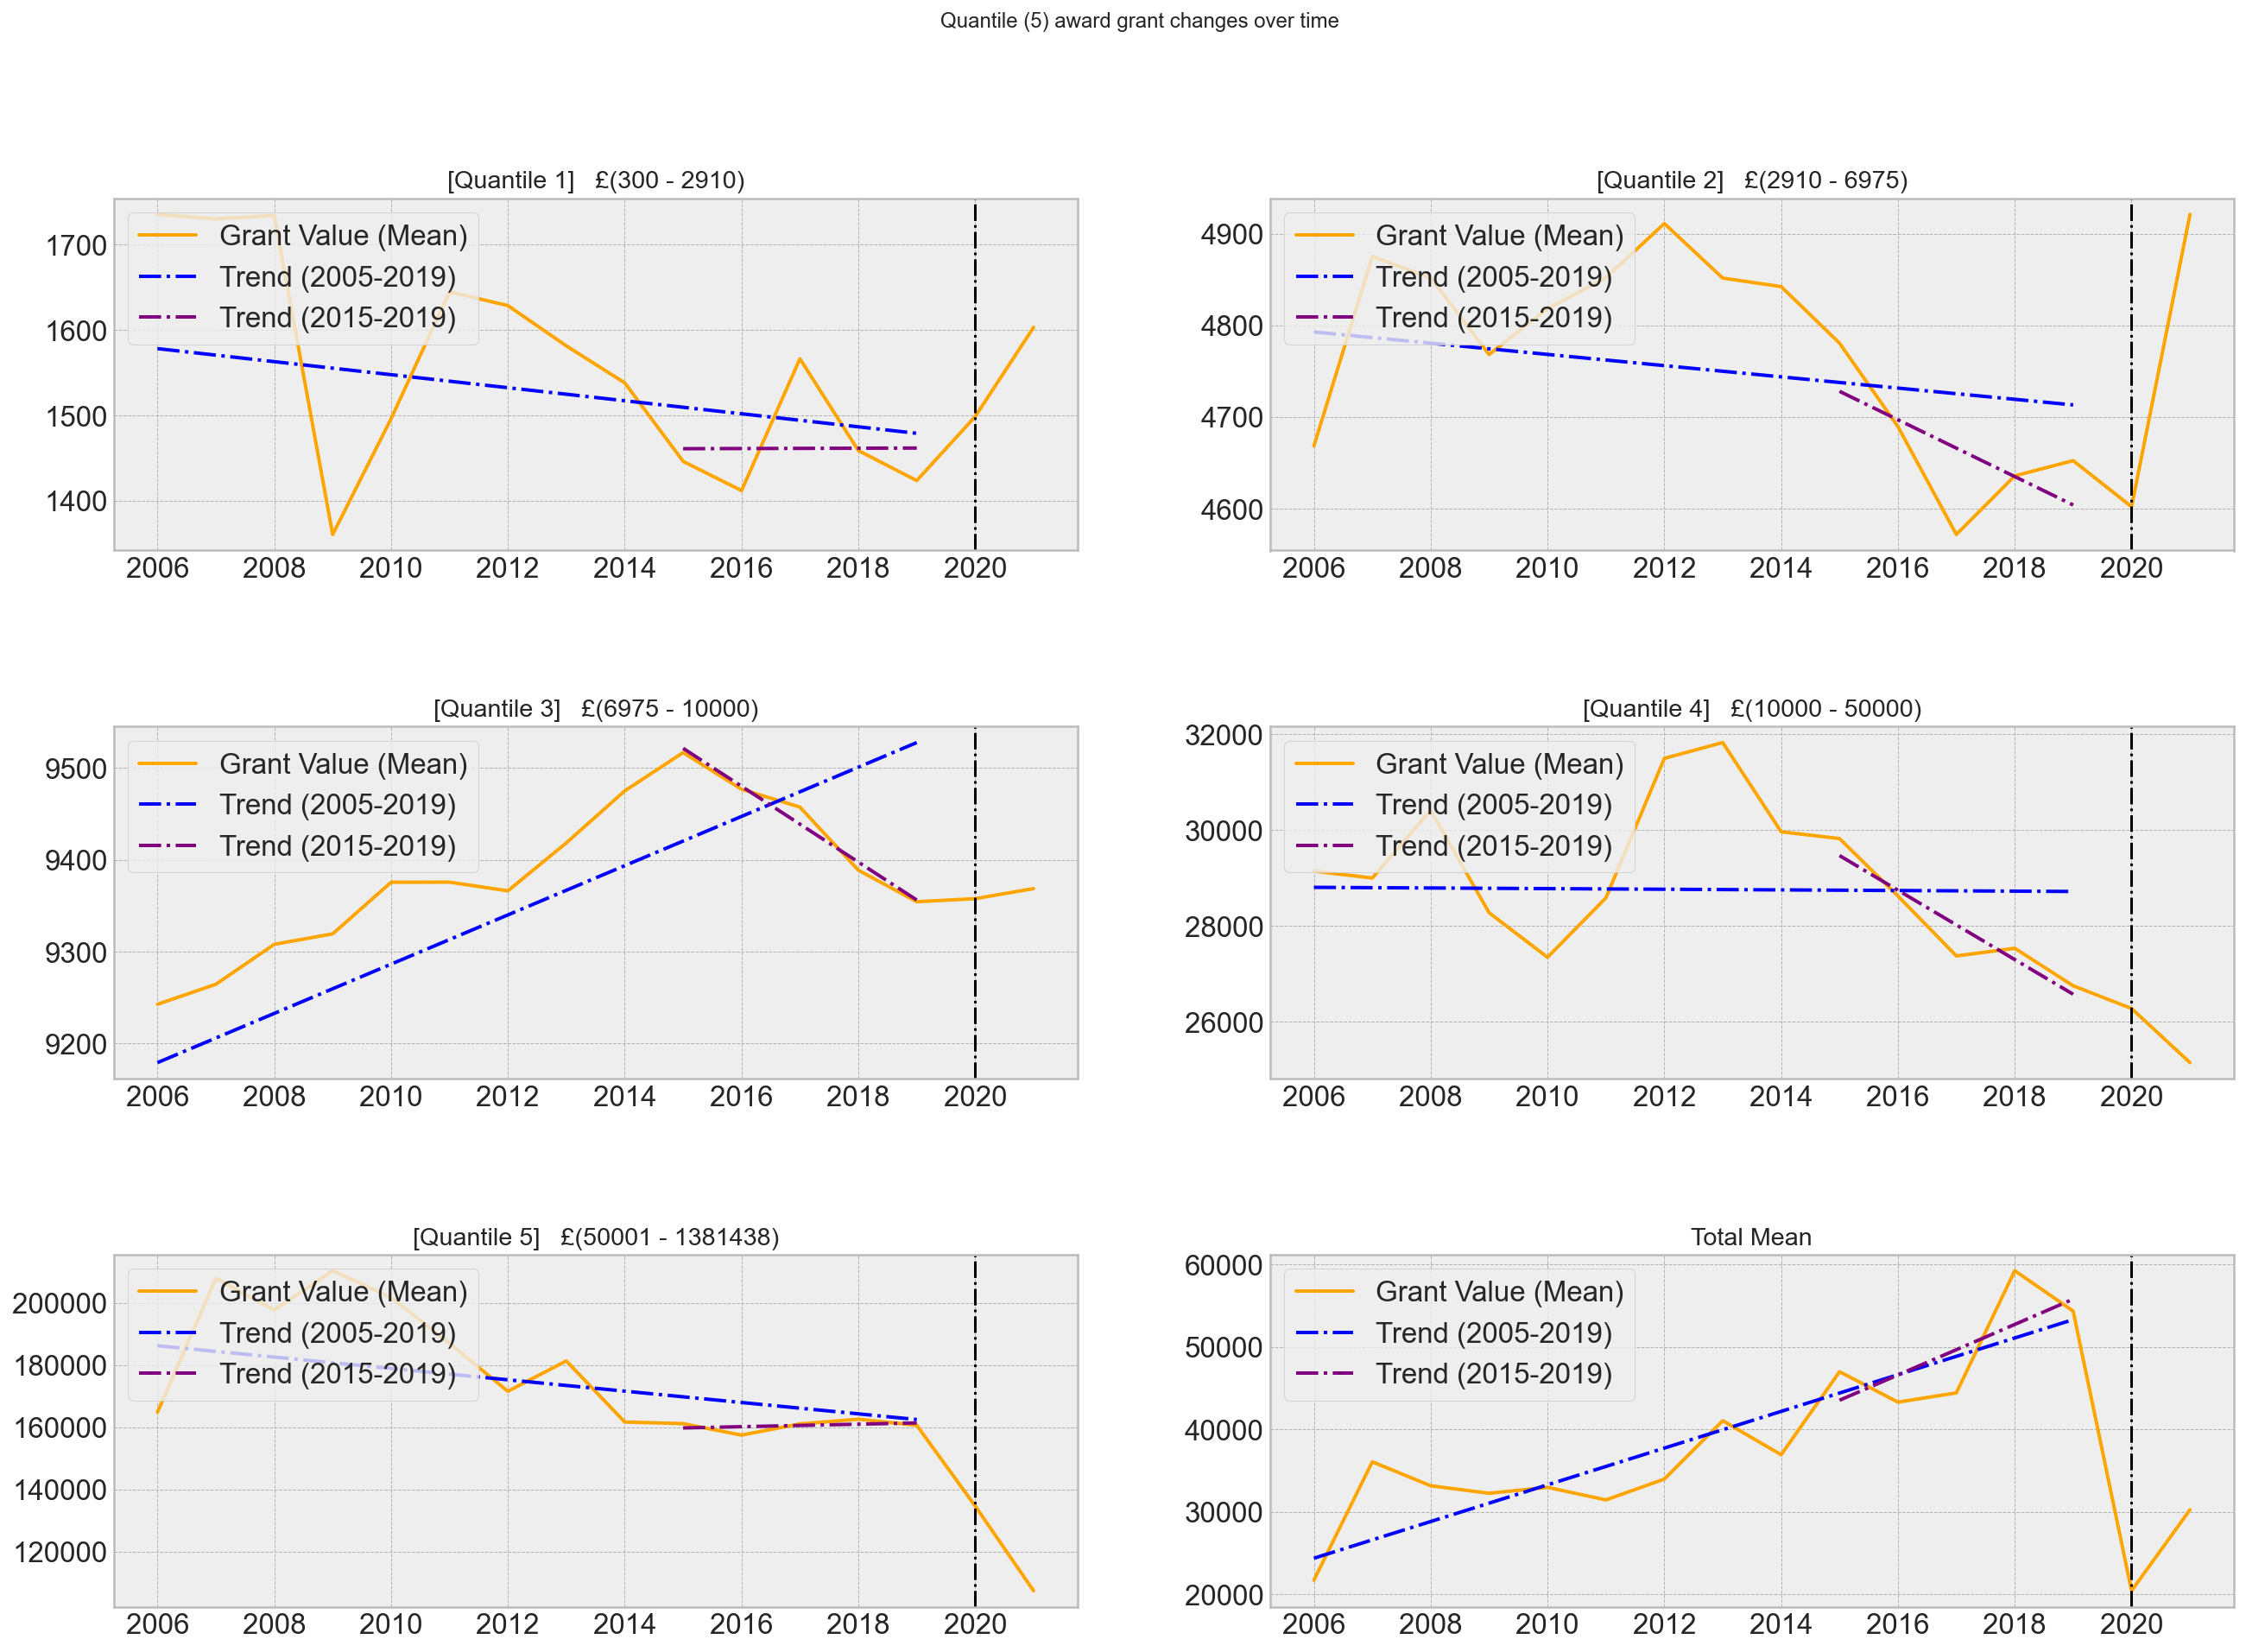

In [128]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(22,15), sharey=False)
fig.subplots_adjust(hspace=0.5)
fig.suptitle(f'Quantile ({percentile_value}) award grant changes over time')

perms = [(i, p[0]) for i in [0,1,2] for p in permutations(range(0,2), 1)]
quants_range = range(1, percentile_value+2)
for p, q in zip(perms, quants_range):
    # get plot data
    if q > 5:
        plot_data = pd.DataFrame(data.groupby('year')['amount_awarded'].mean())
    else:
        plot_data = pd.DataFrame(quartile_groups.loc[idx[:, q], :].reset_index().set_index('year', drop=True)['amount_awarded'])
    # add a trendlines
    plot_data.reset_index(inplace=True)
    model15 = sm.formula.ols(formula='amount_awarded ~ year', data=plot_data.iloc[9:-2,:]) # 11:-1 = 2005 - 2019
    res15 = model15.fit()
    plot_data['trend_15y'] = res15.fittedvalues
    model5 = sm.formula.ols(formula='amount_awarded ~ year', data=plot_data.iloc[19:-2,:]) # 19:-1 = 2005 - 2019
    res5 = model5.fit()
    plot_data['trend_5y'] = res5.fittedvalues
    plot_data.set_index('year', drop=True, inplace=True)
    # plot grants and trendline
    plot_data = plot_data.iloc[10:,:]
    axes[p].plot(plot_data['amount_awarded'], color='orange', label='Grant Value (Mean)')
    axes[p].plot(plot_data['trend_15y'], color='blue', linestyle='-.', label='Trend (2005-2019)')
    axes[p].plot(plot_data['trend_5y'], color='purple', linestyle='-.', label='Trend (2015-2019)')
    # add min and max so we know what the quantiles refer to
    if q <= 5:
        qmin = min_max_dict[q]['min']
        qmax = min_max_dict[q]['max']
        axes[p].set_title(f"[Quantile {q}]   \u00A3({int(qmin)} - {int(qmax)})")
    else:
        axes[p].set_title(f"Total Mean")
    axes[p].axvline((2020), color='black', linestyle='-.', linewidth=1.5)
    axes[p].legend(loc='upper left')
plt.show();

It's likely that the overall trend seen in the 3rd quintile above could affect the predictions if we use beyond 5 years.  Quintile 1 and 5 and going in oppositive directions so there is a good case to reduce the dataset to grants made in the last 5 years. 

In [160]:
data_2015_plus = data[data['award_date']>'2015-01-01'].iloc[:,:-1].reset_index(drop=True)

In [163]:
data_2015_plus.head()

identifier currency  \
0  360G-cabinetoffice-GA-060628      GBP   
1  360G-cabinetoffice-GA-060629      GBP   
2  360G-cabinetoffice-GA-060655      GBP   
3  360G-cabinetoffice-GA-060682      GBP   
4  360G-cabinetoffice-GA-060074      GBP   

                                               title  \
0  Bus Service Operator Grants (outside London) 2...   
1  Bus Service Operator Grants (outside London) 2...   
2  Transport Technology Research Innovation Grant...   
3  Transport Technology Research Innovation Grant...   
4  Bus Service Operator Grants (outside London) 2...   

                                         description  amount_awarded  \
0                                        Placeholder           569.0   
1                                        Placeholder          1089.0   
2  A camera that uses radio frequency signals to ...         36033.0   
3  Developing a novel technique using radar refle...         23650.0   
4                                        Placeholder         14279.0   

  award_date        recipient_org_identifier  \
0 2016-04-01     360G-cabinetoffice-DfT_BS82   
1 2016-04-01                  GB-CHC-1111971   
2 2016-10-03                 GB-COH-RC000668   
3 2016-10-03                 GB-COH-RC000151   
4 2016-04-01  360G-cabinetoffice-GB885340992   

                                recipient_org_name funding_org_identifier  \
0  The Village Bus Committee of Amberley & Slindon              GB-GOR-D9   
1       Totnes and Rural Community Bus Association              GB-GOR-D9   
2                         University of Portsmouth              GB-GOR-D9   
3                             Cranfield University              GB-GOR-D9   
4                                   Cotswold Green              GB-GOR-D9   

           funding_org_name  planned_dates_duration_months  year  
0  Department for Transport                           12.0  2016  
1  Department for Transport                           12.0  2016  
2  Department for Transport                            4.0  2016  
3  Department for Transport                            5.0  2016  
4  Department for Transport                           12.0  2016

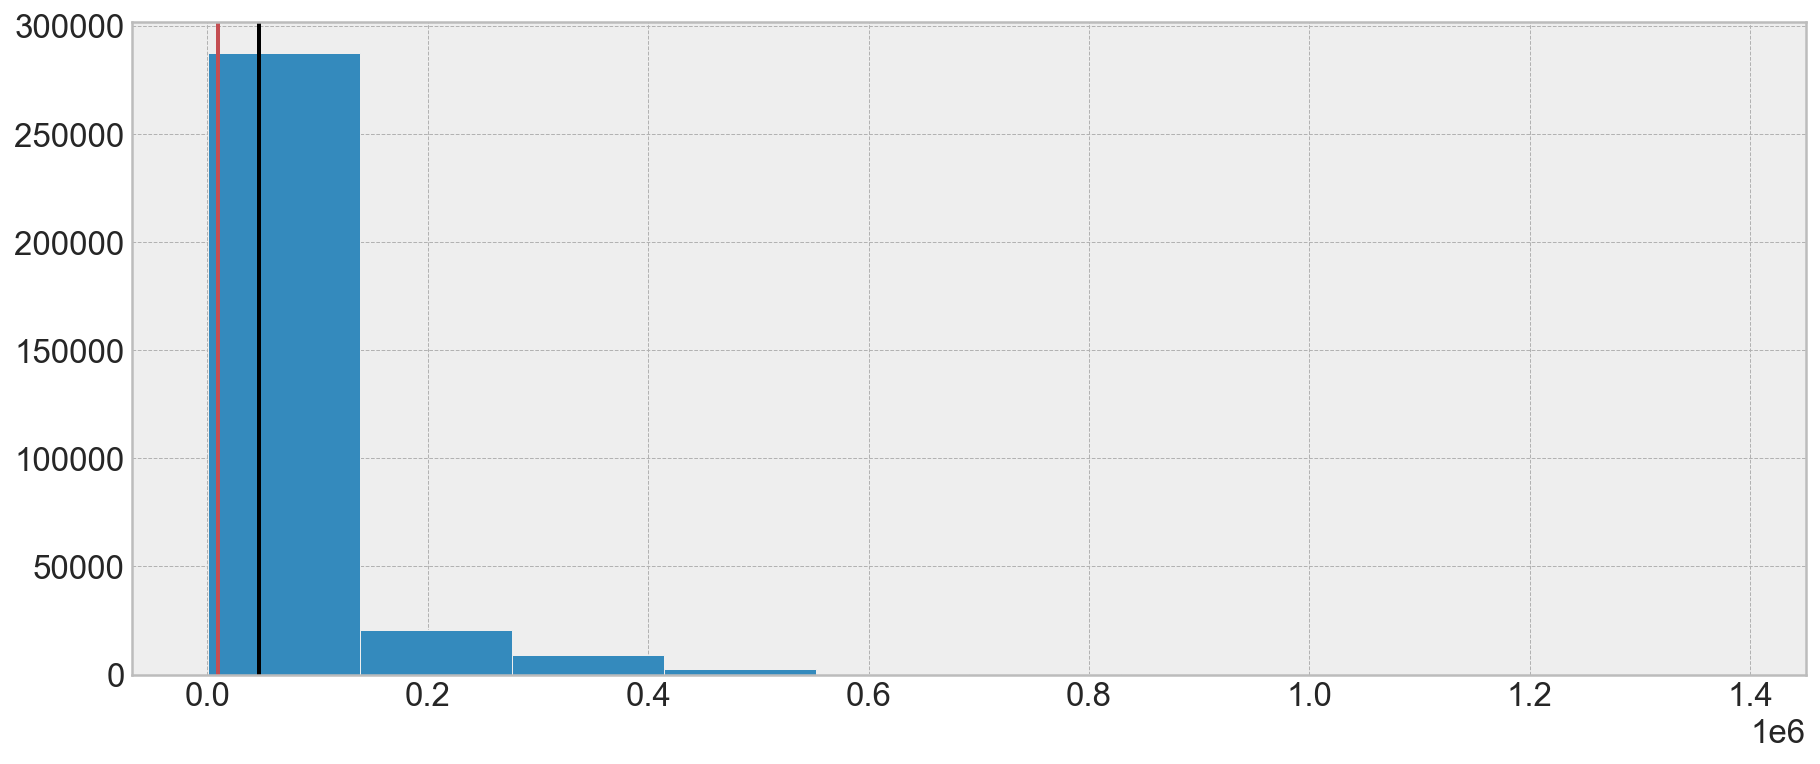

In [161]:
data_2015_plus['amount_awarded'].hist(figsize=(15,6))
plt.axvline(int(round(data_2015_plus['amount_awarded'].mean(),0)), color='black')
plt.axvline(int(round(data_2015_plus['amount_awarded'].median(),0)), color='r')
plt.show();

In [162]:
# save data
data_2015_plus.to_csv(pj(interim_dir,'grantnav_data_post2015.csv'))